<a href="https://colab.research.google.com/github/sprdnv/nlp/blob/master/nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/'My Drive'/nlp
import os
os.getcwd()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/nlp


'/gdrive/My Drive/nlp'

Загрузка необходимых библиотек

In [ ]:
!pip install pymorphy2
import numpy as np
import pandas as pd
import re
import math
from gensim.models import Word2Vec
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression

     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 7.1MB 21.0MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Загрузка и просмотр данных

In [ ]:
data = pd.read_csv('train_content.csv')
print('Data shape:{}'.format(data.shape))
data.head()

Data shape:(172913, 13)


,_id,date,tags,title,hubs_title,description,name,hub,png,nick,url,content,favs_lognorm
0,https://geektimes.ru/post/21866/,2008-03-17T18:55:00.000Z,"['eeepc', 'asus', 'ЭТО', 'эльдорадо', 'ура']",eeePC в продаже. Да. Правда.,Железо,"Итак, если 3 дня назад я отписался то что в пр...",Сергей 'pokatusher',hub/hardware,https://habrastorage.org/getpro/habr/olpicture...,@M_org,https://geektimes.ru/users/M_org,"Итак, если 3 дня назад я <a href=""http://habra...",2.484907
1,https://habrahabr.ru/company/aladdinrd/blog/30...,2016-06-24T13:02:00.000Z,"['Интеграция', 'шифрование', 'Windows', 'Win32...",«Разрубить Гордиев узел» или преодоление пробл...,Системное программирование,Современная операционная система это сложный и...,Аладдин Р.Д.,hub/system_programming,https://habrastorage.org/files/cbd/cf9/5ff/cbd...,NaN,https://habrahabr.ru/company/aladdinrd,Современная операционная система это сложный и...,4.174387
2,https://geektimes.ru/post/92887/,2010-05-06T10:00:00.000Z,"['mc', 'midnight commander', 'diffview', 'merg...",Релиз Midnight Commander 4.7.2 и 4.7.0.5,Чёрная дыра,Спустя 2 месяца упорных трудов вышла новая вер...,Илья Маслаков,hub/closet,https://geektimes.ru/images/logo.png,@smind,https://geektimes.ru/users/smind,Спустя 2 месяца упорных трудов вышла новая вер...,0.000000
3,https://habrahabr.ru/post/290824/,2015-05-22T11:01:00.000Z,"['бизнес-модель', 'бизнес-моделирование']",7 шагов для постройки правильной бизнес-модели,Интернет-маркетинг,Большинство IT предпринимателей сосредотачиваю...,Александр,hub/internetmarketing,https://habrastorage.org/files/50e/211/9a0/50e...,@jasiejames,https://habrahabr.ru/users/jasiejames,"<img src=""https://habrastorage.org/files/50e/2...",3.496508
4,https://habrahabr.ru/post/190088/,2014-09-04T00:32:00.000Z,"['python', 'flask', 'mongodb', 'pet-project']",Thunderargs: практика использования. Часть 2,Программирование,История создания Часть 1 Добрый день. Вкратце...,Данияр Супиев,hub/programming,https://habrahabr.ru/i/habralogo.jpg,@uthunderbird,https://habrahabr.ru/users/uthunderbird,"<a href=""http://habrahabr.ru/post/223041/"">Ист...",3.688879


Добавим новый столбец, соответствущий длине статьи

In [ ]:
data['content'] = data['content'].apply(str)
data['len_of_rev'] = [len(text) for text in data['content']]

Преобразуем дату к более удобному формату и посмотрим на то, как распределены количество и средние длины статей по годам

In [ ]:
data['date'] = data['date'].apply(pd.to_datetime)
data['year'] = data['date'].apply(lambda x: x.year)
data['month'] = data['date'].apply(lambda x: x.month)
data.pivot_table(index='month', columns='year', values=['content', 'len_of_rev'], aggfunc={'content' : 'count', 'len_of_rev' : 'mean'}, margins=True).round()

content                             ... len_of_rev                          
year     2006     2007     2008     2009  ...       2014     2015     2016     All
month                                     ...                                     
1         2.0    667.0    996.0   1373.0  ...    10062.0   8955.0   8998.0  6497.0
2         NaN    950.0   1137.0   1402.0  ...     9669.0   8230.0   9695.0  6198.0
3         3.0   1153.0   1191.0   1646.0  ...     9340.0   8318.0   9399.0  6183.0
4         7.0   1383.0   1406.0   1501.0  ...     9507.0   8555.0   9661.0  6284.0
5        39.0   1189.0   1419.0   1254.0  ...     9483.0   8907.0   9549.0  6179.0
6       125.0   1396.0   1174.0   1232.0  ...     9678.0   8720.0  11997.0  6571.0
7       321.0    960.0   1368.0   1450.0  ...     9947.0   9405.0  11609.0  6634.0
8       328.0    911.0   1365.0   1453.0  ...     9957.0   9208.0  12566.0  6856.0
9       284.0    713.0   1535.0   1515.0  ...     9772.0   9225.0  12872.0  6946.0
10      605.0    885.0   1342.0   1539.0  ...     9579.0   9105.0  12228.0  6796.0
11      587.0    991.0   1149.0   1593.0  ...     9620.0   9412.0  12790.0  6976.0
12      632.0   1041.0   1381.0   1631.0  ...     9276.0  10037.0  12547.0  7050.0
All    2933.0  12239.0  15463.0  17589.0  ...     9645.0   9012.0  10979.0  6600.0

[13 rows x 24 columns]

Будем работать только с текстами 2016 года 

In [ ]:
data = data[data.year == 2016]

Для большей наглядности дискретезируем значения оценки популярности статьи и будем предсказывать уже их. Все статьи, оценки которых ниже 20 перцентиля распределения оценок, пометим 0; статьи с оценками в диапазоне от 20 до 40 перцентеля пометим 1 и т.д. В итоге получаем достаточно сбалансированный набор классов

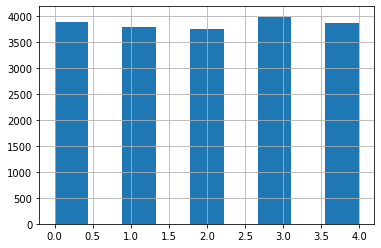

In [ ]:
data['label'] = np.digitize(data.favs_lognorm, data.favs_lognorm.quantile([0.2,0.4,0.6,0.8]))
data.label.hist(bins=9)

Очистка данных: удаление лишних столбоц, сортировка по дате

In [ ]:
droped = ['_id','tags','title','hubs_title','description','name','hub','png','nick','url', 'date', 'len_of_rev', 'index']
data.sort_values(by=['month'], inplace=True)
data.reset_index(inplace=True)
data.drop(columns=droped, inplace=True)
print('Data shape:{}'.format(data.shape))
data.head()

Data shape:(19280, 5)


,content,favs_lognorm,year,month,label
0,"Совсем недавно, а точнее 14 января 2016 года, ...",3.583519,2016,1,2
1,Разработчик Илья Григорик из Google в своём бл...,2.833213,2016,1,1
2,"<img src=""https://habrastorage.org/getpro/habr...",4.369448,2016,1,3
3,Помните свою первую программу? Наверняка она б...,3.178054,2016,1,1
4,"<a href=""https://habrahabr.ru/company/latera/b...",4.852030,2016,1,4


Функция для предварительной обработки текста: удаление пунктуации, html тегов, токенизация, удаление стоп-слов, лемматизация

In [ ]:
def text_preprocessing(text, stops, morph):
    new_text = BeautifulSoup(text, 'html.parser').get_text(separator=' ')
    new_text = re.sub('[^а-яА-Яa-zA-Z\s]', ' ', new_text)
    new_text = re.sub('[^\w+]', ' ', new_text).lower().split()
    new_text = [w for w in new_text if not w in stops]
    new_text = [morph.parse(w)[0].normal_form for w in new_text]
    return new_text

Предварительная обработка текста, сохранение данных для повторного использования

In [ ]:
new_content = []
stops = set(stopwords.words("english")) | set(stopwords.words("russian"))
morph = MorphAnalyzer()
for i,rev in enumerate(data.content):
  new_content.append(text_preprocessing(rev, stops, morph))
data['new_content'] = new_content
data.to_pickle('./data.pkl')

Загрузка и разбиение данных на учебную и тестовую выборки

In [ ]:
#data = pd.read_pickle('data.pkl')
data.new_content = [' '.join(text) for text in data.new_content]
x_train, x_test, y_train, y_test = train_test_split(data.new_content, data.label, test_size=0.2, stratify=data.label, random_state=42)

Начнем с самых простых моделей: BoW, TfIdf

In [ ]:
reg = make_pipeline(CountVectorizer(), LogisticRegression())
reg.fit(x_train, y_train)
print(classification_report(y_test, reg.predict(x_test)))
print(round(roc_auc_score(y_test, reg.predict_proba(x_test), multi_class='ovo'), 3))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.55      0.54      0.55       778
           1       0.31      0.31      0.31       756
           2       0.27      0.28      0.27       751
           3       0.31      0.29      0.30       797
           4       0.50      0.52      0.51       774

    accuracy                           0.39      3856
   macro avg       0.39      0.39      0.39      3856
weighted avg       0.39      0.39      0.39      3856

0.69


In [ ]:
reg = make_pipeline(TfidfVectorizer(), LogisticRegression())
reg.fit(x_train, y_train)
print(classification_report(y_test, reg.predict(x_test)))
print(round(roc_auc_score(y_test, reg.predict_proba(x_test), multi_class='ovo'), 3))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.56      0.63      0.59       778
           1       0.31      0.29      0.30       756
           2       0.29      0.25      0.27       751
           3       0.32      0.29      0.31       797
           4       0.52      0.62      0.56       774

    accuracy                           0.42      3856
   macro avg       0.40      0.41      0.41      3856
weighted avg       0.40      0.42      0.41      3856

0.757


Обучение Word2Vec модели на наших данных

In [ ]:
habr_model = Word2Vec(data.new_content.str.split(), size=300, window=10)

Функция для усреднения полученных представлений для каждой статьи

In [ ]:
def get_doc_vec(words, model):
    good_words = []
    for word in words:
        try:
            if model[word] is not None:
                good_words.append(word)
        except:
            continue
    if len(good_words) == 0:
        return None
    return model[good_words].mean(axis=0)

Усреднение представлений и разбиение данных на учебную и тестовую выборки

In [ ]:
x = data.new_content.str.split().map(lambda text: get_doc_vec(text, habr_model))
x_train, x_test, y_train, y_test = train_test_split(np.stack(x), data.label, test_size=0.2, stratify=data.label, random_state=42)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Логистическая регрессия на word2vec представлениях

In [ ]:
reg = LogisticRegression()
reg.fit(x_train, y_train)
print(classification_report(y_test, reg.predict(x_test)))
print(round(roc_auc_score(y_test, reg.predict_proba(x_test), multi_class='ovo'), 3))

              precision    recall  f1-score   support

           0       0.52      0.58      0.55       778
           1       0.28      0.29      0.29       756
           2       0.30      0.22      0.25       751
           3       0.33      0.30      0.31       797
           4       0.48      0.59      0.53       774

    accuracy                           0.40      3856
   macro avg       0.38      0.40      0.39      3856
weighted avg       0.39      0.40      0.39      3856

0.733


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Воспользуемся более сложной моделью. Опишем небольшую нейросеть

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Dense(512, input_shape=(300,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               154112    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)                

Обучим модель на протяжении 20 эпох и сохраним лучшие веса

In [ ]:
checkpointer = ModelCheckpoint(filepath='top-weights.hdf5', verbose=1, save_best_only=True)
model.fit(x_train, y_train, batch_size=32, epochs=20, callbacks=[checkpointer], validation_data=(x_test, y_test))

Epoch 1/20
482/482 [==============================] - ETA: 0s - loss: 1.4578
Epoch 00001: val_loss improved from inf to 1.36066, saving model to top-weights.hdf5
482/482 [==============================] - 3s 6ms/step - loss: 1.4578 - val_loss: 1.3607
Epoch 2/20
474/482 [============================>.] - ETA: 0s - loss: 1.3896
Epoch 00002: val_loss improved from 1.36066 to 1.34010, saving model to top-weights.hdf5
482/482 [==============================] - 2s 5ms/step - loss: 1.3880 - val_loss: 1.3401
Epoch 3/20
478/482 [============================>.] - ETA: 0s - loss: 1.3711
Epoch 00003: val_loss did not improve from 1.34010
482/482 [==============================] - 2s 5ms/step - loss: 1.3707 - val_loss: 1.3482
Epoch 4/20
478/482 [============================>.] - ETA: 0s - loss: 1.3607
Epoch 00004: val_loss did not improve from 1.34010
482/482 [==============================] - 2s 5ms/step - loss: 1.3602 - val_loss: 1.3478
Epoch 5/20
480/482 [============================>.] - ETA: 0

In [ ]:
model.load_weights('top-weights.hdf5')
print(classification_report(y_test, np.argmax(model.predict(x_test),axis=1)))
print(round(roc_auc_score(y_test, model.predict(x_test), multi_class='ovo'),3))

              precision    recall  f1-score   support

           0       0.57      0.60      0.59       778
           1       0.32      0.33      0.33       756
           2       0.29      0.16      0.20       751
           3       0.32      0.35      0.33       797
           4       0.51      0.66      0.58       774

    accuracy                           0.42      3856
   macro avg       0.40      0.42      0.41      3856
weighted avg       0.40      0.42      0.41      3856

0.751


Попробуем использовать для нашей задачи предобученную модель BERT, на выход который добавим полносвязный слой

In [2]:
x_train, x_test, y_train, y_test = train_test_split(data.new_content, data.label, test_size=0.2, stratify=data.label, random_state=42)
train = pd.DataFrame({'content':x_train, 'label':y_train})
test = pd.DataFrame({'content':x_test, 'label':y_test})
del x_train, x_test, y_train, y_test, data

Импортируем tensorflow, а также некоторые необходимые файлы для работы BERTa

In [3]:
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
import run_classifier
import optimization
import tokenization

In [4]:
train_InputExamples = train.apply(lambda x: run_classifier.InputExample(guid=None, text_a = x['content'], text_b = None, label = x['label']), axis = 1)
test_InputExamples = test.apply(lambda x: run_classifier.InputExample(guid=None, text_a = x['content'], text_b = None, label = x['label']), axis = 1)

In [5]:
BERT_MODEL_HUB = 'https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1'
def create_tokenizer_from_hub_module():
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"], tokenization_info["do_lower_case"]])
  return tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Преобразование текста в подходящий формат

In [6]:
MAX_SEQ_LENGTH = 384
label_list = [0,1,2,3,4]
train_features = run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 15424


INFO:tensorflow:Writing example 0 of 15424


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] герой да ##ть за ##мет ##ка got ##way m ##cm не ##ког ##да топ ##овый кол ##ес ##о который быть новый ма ##кс ##има ##льный комп ##лект ##ация про ##ез ##жать шесть ##де ##сят километр ма ##кс ##има ##льный скорость около три ##дцать километр час н ##ын ##че кол ##ес ##о ос ##тать ##ся за ##менить по ##чини ##ть ба ##тар ##ея кол ##ес ##о ма ##рка kings ##ong кон ##тро ##ллер е ##же ##ли память из ##мен ##ять got ##way m ##cm м ##отор сто ##ять под ##ши ##п ##ник г ##п ##з корпус па ##ян ##ый шп ##ат ##лева ##н по ##к ##рас ##ить за ##мет ##ка основа ##ть качестве ##нный ф ##ото ##графия который сделать время ремонт перед ##ел ##ка тот кто п ##уга ##ть бу ##ква про ##сить ка ##т наш раз ##бор ##ка начин ##ать от ##вора ##чив ##ать само ##рез ##а который с ##к ##ре ##п ##лять два половина корпус затем мы не ##об ##ходи ##мый от ##к ##ру ##тить ви ##нт который со ##еди ##нять корпус др ##опа ##ут сто ##йка п ##еда ##ль вид другой р ##аку ##рс ви ##нт в ##ечн

INFO:tensorflow:tokens: [CLS] герой да ##ть за ##мет ##ка got ##way m ##cm не ##ког ##да топ ##овый кол ##ес ##о который быть новый ма ##кс ##има ##льный комп ##лект ##ация про ##ез ##жать шесть ##де ##сят километр ма ##кс ##има ##льный скорость около три ##дцать километр час н ##ын ##че кол ##ес ##о ос ##тать ##ся за ##менить по ##чини ##ть ба ##тар ##ея кол ##ес ##о ма ##рка kings ##ong кон ##тро ##ллер е ##же ##ли память из ##мен ##ять got ##way m ##cm м ##отор сто ##ять под ##ши ##п ##ник г ##п ##з корпус па ##ян ##ый шп ##ат ##лева ##н по ##к ##рас ##ить за ##мет ##ка основа ##ть качестве ##нный ф ##ото ##графия который сделать время ремонт перед ##ел ##ка тот кто п ##уга ##ть бу ##ква про ##сить ка ##т наш раз ##бор ##ка начин ##ать от ##вора ##чив ##ать само ##рез ##а который с ##к ##ре ##п ##лять два половина корпус затем мы не ##об ##ходи ##мый от ##к ##ру ##тить ви ##нт который со ##еди ##нять корпус др ##опа ##ут сто ##йка п ##еда ##ль вид другой р ##аку ##рс ви ##нт в ##ечн

INFO:tensorflow:input_ids: 101 48074 10405 11258 10234 50362 10521 19556 14132 181 27528 10375 29476 10987 56575 43206 90363 17488 10316 12968 17631 30994 97744 18705 17804 23323 58210 100405 38878 12709 32934 59919 60406 12265 83125 89242 97744 18705 17804 23323 61735 13753 13251 93283 89242 12562 554 12119 13873 90363 17488 10316 85854 91119 10625 10234 94002 10297 32615 11258 13571 13780 24377 90363 17488 10316 97744 23739 79836 13891 33023 62735 84758 546 15920 10783 52649 10387 14402 20177 19556 14132 181 27528 553 95972 108804 20177 11429 13523 11078 11718 544 11078 11571 29785 12634 18971 13865 13568 12378 72412 10267 10297 10510 56680 15356 10234 50362 10521 53277 11258 17164 28501 561 19517 31798 12968 58073 11657 90282 18731 13519 10521 24486 35261 556 40362 11258 18261 34790 12709 99366 56280 10351 79590 17257 20545 10521 27353 18235 10332 59788 40181 18235 14847 102233 10179 12968 558 10510 14348 11078 32589 12500 50178 29785 16907 35818 10375 33276 58933 50911 10332 10510 

INFO:tensorflow:input_ids: 101 48074 10405 11258 10234 50362 10521 19556 14132 181 27528 10375 29476 10987 56575 43206 90363 17488 10316 12968 17631 30994 97744 18705 17804 23323 58210 100405 38878 12709 32934 59919 60406 12265 83125 89242 97744 18705 17804 23323 61735 13753 13251 93283 89242 12562 554 12119 13873 90363 17488 10316 85854 91119 10625 10234 94002 10297 32615 11258 13571 13780 24377 90363 17488 10316 97744 23739 79836 13891 33023 62735 84758 546 15920 10783 52649 10387 14402 20177 19556 14132 181 27528 553 95972 108804 20177 11429 13523 11078 11718 544 11078 11571 29785 12634 18971 13865 13568 12378 72412 10267 10297 10510 56680 15356 10234 50362 10521 53277 11258 17164 28501 561 19517 31798 12968 58073 11657 90282 18731 13519 10521 24486 35261 556 40362 11258 18261 34790 12709 99366 56280 10351 79590 17257 20545 10521 27353 18235 10332 59788 40181 18235 14847 102233 10179 12968 558 10510 14348 11078 32589 12500 50178 29785 16907 35818 10375 33276 58933 50911 10332 10510 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ф ##ото gr ##over net cc один наш пред ##ы ##ду ##щий материал п ##иса ##ть новый раз ##работка с ##фера х ##ранение да ##ть ia ##as про ##вай ##дер очень интерес ##овать тех ##нология с ##пособ ##ный из ##менить наш представлен ##ие дата центр р ##еши ##ть у ##дел ##ить немного время х ##рани ##лище да ##ть очень ё ##мки ##й х ##рани ##лище да ##ть год компания sea ##gate ан ##он ##си ##ровать свой новый диск ##овый на ##коп ##итель kin ##eti ##c h ##dd ин ##тер ##фей ##с et ##her ##net про ##из ##водит ##ельно ##сть который несколько пре ##вы ##сить про ##из ##водит ##ельно ##сть су ##ществ ##ую ##щий момент продукт компания новое из ##об ##рет ##ение у ##про ##щать процесс создание программ ##ный а ##п ##парат ##ный архитектура х ##ранение да ##ть с ##ни ##жать сов ##ок ##уп ##ный сто ##имость в ##ладение т ##со по ##зв ##оля ##ть опера ##тивно р ##е ##аг ##ировать р ##аст ##и по ##тр ##ебно ##сть обл ##ач ##ный ин ##ф ##рас ##труктура система х ##ранен

INFO:tensorflow:tokens: [CLS] ф ##ото gr ##over net cc один наш пред ##ы ##ду ##щий материал п ##иса ##ть новый раз ##работка с ##фера х ##ранение да ##ть ia ##as про ##вай ##дер очень интерес ##овать тех ##нология с ##пособ ##ный из ##менить наш представлен ##ие дата центр р ##еши ##ть у ##дел ##ить немного время х ##рани ##лище да ##ть очень ё ##мки ##й х ##рани ##лище да ##ть год компания sea ##gate ан ##он ##си ##ровать свой новый диск ##овый на ##коп ##итель kin ##eti ##c h ##dd ин ##тер ##фей ##с et ##her ##net про ##из ##водит ##ельно ##сть который несколько пре ##вы ##сить про ##из ##водит ##ельно ##сть су ##ществ ##ую ##щий момент продукт компания новое из ##об ##рет ##ение у ##про ##щать процесс создание программ ##ный а ##п ##парат ##ный архитектура х ##ранение да ##ть с ##ни ##жать сов ##ок ##уп ##ный сто ##имость в ##ладение т ##со по ##зв ##оля ##ть опера ##тивно р ##е ##аг ##ировать р ##аст ##и по ##тр ##ебно ##сть обл ##ач ##ный ин ##ф ##рас ##труктура система х ##ранен

INFO:tensorflow:input_ids: 101 561 19517 30518 16666 11988 13774 13713 79590 23807 10292 15986 27312 67409 556 51116 11258 30994 17257 44097 558 52263 562 110511 10405 11258 12729 10403 12709 37914 22605 20598 59075 55017 32323 80282 558 97205 11092 10387 94002 79590 90005 12686 58154 15840 557 95135 11258 560 44030 15356 90126 11657 562 32229 89990 10405 11258 20598 574 54929 10384 562 32229 89990 10405 11258 11974 30115 14931 21305 69864 11579 13700 34234 20820 30994 69407 43206 10122 82947 49280 37403 16490 10350 176 12969 27796 15469 89168 10513 10131 14206 12978 12709 39457 69290 49161 12737 12968 15981 38494 18221 99366 12709 39457 69290 49161 12737 10587 92157 14611 27312 20658 65501 30115 65647 10387 33276 40035 16241 560 104082 80288 45234 56875 84515 11092 541 11078 41895 11092 84506 562 110511 10405 11258 558 10656 59919 98903 11899 53190 11092 108804 73434 543 93928 559 30604 10297 105283 74269 11258 57972 45709 557 10205 51229 79187 557 31016 10191 10297 46672 102298 12737

INFO:tensorflow:input_ids: 101 561 19517 30518 16666 11988 13774 13713 79590 23807 10292 15986 27312 67409 556 51116 11258 30994 17257 44097 558 52263 562 110511 10405 11258 12729 10403 12709 37914 22605 20598 59075 55017 32323 80282 558 97205 11092 10387 94002 79590 90005 12686 58154 15840 557 95135 11258 560 44030 15356 90126 11657 562 32229 89990 10405 11258 20598 574 54929 10384 562 32229 89990 10405 11258 11974 30115 14931 21305 69864 11579 13700 34234 20820 30994 69407 43206 10122 82947 49280 37403 16490 10350 176 12969 27796 15469 89168 10513 10131 14206 12978 12709 39457 69290 49161 12737 12968 15981 38494 18221 99366 12709 39457 69290 49161 12737 10587 92157 14611 27312 20658 65501 30115 65647 10387 33276 40035 16241 560 104082 80288 45234 56875 84515 11092 541 11078 41895 11092 84506 562 110511 10405 11258 558 10656 59919 98903 11899 53190 11092 108804 73434 543 93928 559 30604 10297 105283 74269 11258 57972 45709 557 10205 51229 79187 557 31016 10191 10297 46672 102298 12737

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ка ##др фильм space ##ball ##s январь ма ##ис ##овый пол на ##ходить ##ся территория в ##ье ##тнам ##ский провинция й ##ен ##бай у ##пас ##ть металл ##ический шар военный вы ##ска ##за ##ть пред ##положен ##ие ки ##лог ##рам ##мов ##ый шар м ##о ##чь ко ##с ##ми ##ческий му ##сор пер ##еж ##ить пад ##ение о ##рби ##та в ##еда т ##ся р ##ас ##след ##ование ин ##ци ##дент известно шар со ##дер ##жим ##ый в ##з ##рыв ##чат ##ый веществ ##о о ##пас ##ный здоров ##ье материал военный у ##тве ##рж ##дать проводить ни ##како ##й у ##чение исп ##ыта ##ние район страна о ##чев ##ид ##ец р ##ассказы ##вать у ##сл ##ыш ##ать звук на ##по ##до ##бие гр ##ом шар у ##пас ##ть небо мест ##ный газета thanh nie ##n по ##с ##пе ##шить со ##об ##щи ##ть пред ##вари ##тельный р ##ас ##след ##ование при ##шлы ##й вы ##вод российский про ##исхождение этот стран ##ный шар ##ов м ##о ##чь частью ракета ко ##с ##ми ##ческий корабль по ##чему сделать вы ##вод пока не ##из ##вестно 

INFO:tensorflow:tokens: [CLS] ка ##др фильм space ##ball ##s январь ма ##ис ##овый пол на ##ходить ##ся территория в ##ье ##тнам ##ский провинция й ##ен ##бай у ##пас ##ть металл ##ический шар военный вы ##ска ##за ##ть пред ##положен ##ие ки ##лог ##рам ##мов ##ый шар м ##о ##чь ко ##с ##ми ##ческий му ##сор пер ##еж ##ить пад ##ение о ##рби ##та в ##еда т ##ся р ##ас ##след ##ование ин ##ци ##дент известно шар со ##дер ##жим ##ый в ##з ##рыв ##чат ##ый веществ ##о о ##пас ##ный здоров ##ье материал военный у ##тве ##рж ##дать проводить ни ##како ##й у ##чение исп ##ыта ##ние район страна о ##чев ##ид ##ец р ##ассказы ##вать у ##сл ##ыш ##ать звук на ##по ##до ##бие гр ##ом шар у ##пас ##ть небо мест ##ный газета thanh nie ##n по ##с ##пе ##шить со ##об ##щи ##ть пред ##вари ##тельный р ##ас ##след ##ование при ##шлы ##й вы ##вод российский про ##исхождение этот стран ##ный шар ##ов м ##о ##чь частью ракета ко ##с ##ми ##ческий корабль по ##чему сделать вы ##вод пока не ##из ##вестно 

INFO:tensorflow:input_ids: 101 56280 51965 20350 16199 19805 10107 19895 97744 19120 43206 23750 10122 47387 10625 65228 543 20554 89743 11386 44431 550 10928 38886 560 36168 11258 100702 27139 108858 55490 96195 12184 13594 11258 23807 71950 12686 14708 22141 42495 33170 13865 108858 553 10316 40697 59781 10513 10508 21551 12388 108493 61381 49867 15356 20279 16241 555 75611 10367 543 63253 559 10625 557 18291 73759 43881 27796 12012 87161 40262 108858 10956 22605 101509 13865 543 11571 77851 48579 13865 103040 10316 555 36168 11092 77770 20554 67409 55490 560 35795 60872 57548 88184 19544 67967 10384 560 21137 37410 86360 13541 14659 18512 555 32702 22415 16688 557 86251 27013 560 102572 23879 18235 83336 10122 53204 17961 108306 55895 10364 108858 560 36168 11258 39483 40592 11092 38459 38762 11058 10115 10297 10513 19820 61260 10956 33276 19682 11258 23807 60048 34548 557 18291 73759 43881 10913 108364 10384 96195 45597 35413 12709 92824 19558 32619 11092 108858 10433 553 10316 406

INFO:tensorflow:input_ids: 101 56280 51965 20350 16199 19805 10107 19895 97744 19120 43206 23750 10122 47387 10625 65228 543 20554 89743 11386 44431 550 10928 38886 560 36168 11258 100702 27139 108858 55490 96195 12184 13594 11258 23807 71950 12686 14708 22141 42495 33170 13865 108858 553 10316 40697 59781 10513 10508 21551 12388 108493 61381 49867 15356 20279 16241 555 75611 10367 543 63253 559 10625 557 18291 73759 43881 27796 12012 87161 40262 108858 10956 22605 101509 13865 543 11571 77851 48579 13865 103040 10316 555 36168 11092 77770 20554 67409 55490 560 35795 60872 57548 88184 19544 67967 10384 560 21137 37410 86360 13541 14659 18512 555 32702 22415 16688 557 86251 27013 560 102572 23879 18235 83336 10122 53204 17961 108306 55895 10364 108858 560 36168 11258 39483 40592 11092 38459 38762 11058 10115 10297 10513 19820 61260 10956 33276 19682 11258 23807 60048 34548 557 18291 73759 43881 10913 108364 10384 96195 45597 35413 12709 92824 19558 32619 11092 108858 10433 553 10316 406

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] весь при ##вет давно п ##иса ##ть х ##аб ##ра который конец про ##шло ##е год вы ##пус ##тить новый версия wire ##n board кон ##тро ##ллер а ##вт ##ома ##ти ##зация открыт ##ый сегодня р ##ассказ ##ать ка ##т с ##ки ##дка вы ##пус ##тить новый версия исп ##рав ##ить н ##рав ##иться пол ##ь ##зова ##тель мы сам у ##вели ##чить в ##д ##вое количество опера ##тив ##ный память м ##бай ##т d ##dr р ##ас ##шир ##ить за ##од ##но ди ##ап ##аз ##он рабочий температура за ##менить по ##тен ##циал ##ьно не ##над ж ##ный карта память micro ##sd ка ##чество п ##зу в ##стр ##ои ##ть память em ##m ##c г ##бай ##т сделать кон ##тро ##ллер м ##оду ##льный м ##о ##чь доба ##в ##лять функция у ##стана ##в ##лива ##ть плато ##к р ##ас ##шир ##ение в ##нут ##рь корпус е ##щ у ##вели ##чив ##ать количество в ##ход выход под ##кл ##ю ##чать бо ##ковой м ##оду ##ль также доба ##вить несколько м ##од ##ный ф ##иш ##ка blue ##to ##oth число low energy порт ин ##ф ##рак ##рас ##ный

INFO:tensorflow:tokens: [CLS] весь при ##вет давно п ##иса ##ть х ##аб ##ра который конец про ##шло ##е год вы ##пус ##тить новый версия wire ##n board кон ##тро ##ллер а ##вт ##ома ##ти ##зация открыт ##ый сегодня р ##ассказ ##ать ка ##т с ##ки ##дка вы ##пус ##тить новый версия исп ##рав ##ить н ##рав ##иться пол ##ь ##зова ##тель мы сам у ##вели ##чить в ##д ##вое количество опера ##тив ##ный память м ##бай ##т d ##dr р ##ас ##шир ##ить за ##од ##но ди ##ап ##аз ##он рабочий температура за ##менить по ##тен ##циал ##ьно не ##над ж ##ный карта память micro ##sd ка ##чество п ##зу в ##стр ##ои ##ть память em ##m ##c г ##бай ##т сделать кон ##тро ##ллер м ##оду ##льный м ##о ##чь доба ##в ##лять функция у ##стана ##в ##лива ##ть плато ##к р ##ас ##шир ##ение в ##нут ##рь корпус е ##щ у ##вели ##чив ##ать количество в ##ход выход под ##кл ##ю ##чать бо ##ковой м ##оду ##ль также доба ##вить несколько м ##од ##ный ф ##иш ##ка blue ##to ##oth число low energy порт ин ##ф ##рак ##рас ##ный

INFO:tensorflow:input_ids: 101 42977 10913 41102 102213 556 51116 11258 562 50889 11079 12968 77431 12709 30474 10205 11974 96195 101012 53407 30994 36560 68033 10115 17936 33023 62735 84758 541 94454 27159 10960 53826 60427 13865 72166 557 95559 18235 56280 10351 558 10648 34885 96195 101012 53407 30994 36560 37410 41410 15356 554 41410 56051 23750 10851 78130 19212 35818 19654 560 53615 34702 543 10746 57798 24750 57972 37921 11092 52649 553 38886 10351 172 59464 557 18291 94219 15356 10234 16625 10636 48575 36744 26313 11579 102732 30405 10234 94002 10297 25263 72459 24675 10375 64086 547 11092 54158 52649 54396 82836 56280 34150 556 19692 543 52685 26891 11258 52649 10266 10147 10350 544 38886 10351 58073 33023 62735 84758 553 54356 23323 553 10316 40697 71516 10541 32589 89977 560 60327 10541 35777 11258 99878 10510 557 18291 94219 16241 543 75029 28301 29785 546 18565 560 53615 40181 18235 24750 543 23089 99914 11429 53869 10593 37020 18481 89738 553 54356 12118 11448 71516 60797

INFO:tensorflow:input_ids: 101 42977 10913 41102 102213 556 51116 11258 562 50889 11079 12968 77431 12709 30474 10205 11974 96195 101012 53407 30994 36560 68033 10115 17936 33023 62735 84758 541 94454 27159 10960 53826 60427 13865 72166 557 95559 18235 56280 10351 558 10648 34885 96195 101012 53407 30994 36560 37410 41410 15356 554 41410 56051 23750 10851 78130 19212 35818 19654 560 53615 34702 543 10746 57798 24750 57972 37921 11092 52649 553 38886 10351 172 59464 557 18291 94219 15356 10234 16625 10636 48575 36744 26313 11579 102732 30405 10234 94002 10297 25263 72459 24675 10375 64086 547 11092 54158 52649 54396 82836 56280 34150 556 19692 543 52685 26891 11258 52649 10266 10147 10350 544 38886 10351 58073 33023 62735 84758 553 54356 23323 553 10316 40697 71516 10541 32589 89977 560 60327 10541 35777 11258 99878 10510 557 18291 94219 16241 543 75029 28301 29785 546 18565 560 53615 40181 18235 24750 543 23089 99914 11429 53869 10593 37020 18481 89738 553 54356 12118 11448 71516 60797

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] про ##шло ##е о ##пус пов ##ерх ##ност ##но о ##писать т ##ре ##бов ##ание пол ##ь ##зова ##тель э ##кс ##п ##лу ##ата ##ционный документ ##ация элемент ##ный база не ##кото ##рый не ##дом ##ол ##вка про ##из ##водит ##ель ми ##к ##рос ##хема h ##m ##c hit ##tit ##e micro ##wave cor ##p да ##ть текст поста ##рат ##ься ос ##вет ##ить се ##рь ##ё ##з ##ный проблема ми ##к ##рос ##хема maa ##p про ##из ##водит ##ель mac ##om t ##s вы ##явление да ##ть проблема сост ##оят ##ься пред ##д ##вер ##ие ст ##ык ##ово ##чный исп ##ыта ##ние изд ##ели ##е по ##на ##чал ##у гр ##еши ##ть основно ##е конс ##тр ##укция наш проект ат ##мос ##фера про ##ни ##за ##ть от ##чая ##ние стать про ##вер ##яться самый без ##ум ##ный идея ф ##ант ##аст ##ический ги ##по ##теза нам ##еча ##ться о ##че ##редно ##й про ##щание семья но ##чной ин ##жени ##рин ##г ф ##аст ##а ф ##уд ко ##фе про ##чий пре ##лес ##ть м ##но ##же ##ственный поп ##ыт ##ка пер ##ек ##рои ##ть кон ##фи ##гура

INFO:tensorflow:tokens: [CLS] про ##шло ##е о ##пус пов ##ерх ##ност ##но о ##писать т ##ре ##бов ##ание пол ##ь ##зова ##тель э ##кс ##п ##лу ##ата ##ционный документ ##ация элемент ##ный база не ##кото ##рый не ##дом ##ол ##вка про ##из ##водит ##ель ми ##к ##рос ##хема h ##m ##c hit ##tit ##e micro ##wave cor ##p да ##ть текст поста ##рат ##ься ос ##вет ##ить се ##рь ##ё ##з ##ный проблема ми ##к ##рос ##хема maa ##p про ##из ##водит ##ель mac ##om t ##s вы ##явление да ##ть проблема сост ##оят ##ься пред ##д ##вер ##ие ст ##ык ##ово ##чный исп ##ыта ##ние изд ##ели ##е по ##на ##чал ##у гр ##еши ##ть основно ##е конс ##тр ##укция наш проект ат ##мос ##фера про ##ни ##за ##ть от ##чая ##ние стать про ##вер ##яться самый без ##ум ##ный идея ф ##ант ##аст ##ический ги ##по ##теза нам ##еча ##ться о ##че ##редно ##й про ##щание семья но ##чной ин ##жени ##рин ##г ф ##аст ##а ф ##уд ко ##фе про ##чий пре ##лес ##ть м ##но ##же ##ственный поп ##ыт ##ка пер ##ек ##рои ##ть кон ##фи ##гура

INFO:tensorflow:input_ids: 101 12709 30474 10205 555 101012 30148 57935 19364 10636 555 106115 559 14348 49455 27473 23750 10851 78130 19212 570 18705 11078 16111 16962 49973 85065 38878 102420 11092 50509 10375 39692 68172 10375 38419 17010 26198 12709 39457 69290 17371 37140 10510 44181 87172 176 10147 10350 14946 23516 10112 54396 85164 29162 10410 10405 11258 39734 80765 23444 26899 85854 41102 15356 10277 28301 25913 11571 11092 66657 37140 10510 44181 87172 49123 10410 12709 39457 69290 17371 57251 10692 188 10107 96195 63049 10405 11258 66657 91908 81802 26899 23807 10746 32418 12686 15888 25531 20007 25711 37410 86360 13541 21529 18400 10205 10297 10409 37322 10227 55895 95135 11258 94261 10205 32243 46672 70555 79590 24494 72701 102006 52263 12709 10656 13594 11258 10332 95156 13541 50121 12709 32418 55295 63600 13012 20392 11092 90636 561 38241 31016 27139 15649 53204 110360 59221 106173 14133 555 13873 97566 10384 12709 96316 66201 11279 28137 27796 84935 28922 10823 561 310

INFO:tensorflow:input_ids: 101 12709 30474 10205 555 101012 30148 57935 19364 10636 555 106115 559 14348 49455 27473 23750 10851 78130 19212 570 18705 11078 16111 16962 49973 85065 38878 102420 11092 50509 10375 39692 68172 10375 38419 17010 26198 12709 39457 69290 17371 37140 10510 44181 87172 176 10147 10350 14946 23516 10112 54396 85164 29162 10410 10405 11258 39734 80765 23444 26899 85854 41102 15356 10277 28301 25913 11571 11092 66657 37140 10510 44181 87172 49123 10410 12709 39457 69290 17371 57251 10692 188 10107 96195 63049 10405 11258 66657 91908 81802 26899 23807 10746 32418 12686 15888 25531 20007 25711 37410 86360 13541 21529 18400 10205 10297 10409 37322 10227 55895 95135 11258 94261 10205 32243 46672 70555 79590 24494 72701 102006 52263 12709 10656 13594 11258 10332 95156 13541 50121 12709 32418 55295 63600 13012 20392 11092 90636 561 38241 31016 27139 15649 53204 110360 59221 106173 14133 555 13873 97566 10384 12709 96316 66201 11279 28137 27796 84935 28922 10823 561 310

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 10000 of 15424


INFO:tensorflow:Writing example 10000 of 15424


INFO:tensorflow:Writing example 0 of 3856


INFO:tensorflow:Writing example 0 of 3856


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] мы не ##из ##ве ##ст ##ный при ##рода том я матери ##я том я э ##нергия состав ##лять наш все ##ленная значи ##т это теория большой в ##з ##рыв под ##ле ##жать со ##м ##нение ва ##ш теория б ##ес ##кон ##ечно ##сть именно этот место пер ##ест том о ##пис ##ывать р ##е ##ально ##сть ко ##с ##мос род ##иться большой в ##з ##рыв б ##ес ##кон ##еч ##ный мы при ##ходить ##ся в ##ери ##ть мг ##нов ##енно стать б ##ес ##кон ##ечно больш ##ий это аб ##су ##рд жа ##нна ле ##вин это не ##кото ##рый род чу ##до несмотря наш з ##нание до ##бы ##ть помощь научный исследование в ##с е ##щ стал ##ки ##ваться вопрос который ответ каждый не ##деля ст ##ара ##ться о ##гор ##ош ##ить м ##ой е ##жен ##еде ##льный коло ##нка свой вопрос предложение не ##деля чи ##тат ##ель j ##lna ##nce с ##пра ##шив ##ать у ##ч н ##ые у ##вер ##ить по ##нимать э ##вол ##ю ##ция все ##ленная прямо самый начало большой в ##з ##рыв у ##вер ##ить все ##ленная сост ##оят ##ь том я матери ##я че ##

INFO:tensorflow:tokens: [CLS] мы не ##из ##ве ##ст ##ный при ##рода том я матери ##я том я э ##нергия состав ##лять наш все ##ленная значи ##т это теория большой в ##з ##рыв под ##ле ##жать со ##м ##нение ва ##ш теория б ##ес ##кон ##ечно ##сть именно этот место пер ##ест том о ##пис ##ывать р ##е ##ально ##сть ко ##с ##мос род ##иться большой в ##з ##рыв б ##ес ##кон ##еч ##ный мы при ##ходить ##ся в ##ери ##ть мг ##нов ##енно стать б ##ес ##кон ##ечно больш ##ий это аб ##су ##рд жа ##нна ле ##вин это не ##кото ##рый род чу ##до несмотря наш з ##нание до ##бы ##ть помощь научный исследование в ##с е ##щ стал ##ки ##ваться вопрос который ответ каждый не ##деля ст ##ара ##ться о ##гор ##ош ##ить м ##ой е ##жен ##еде ##льный коло ##нка свой вопрос предложение не ##деля чи ##тат ##ель j ##lna ##nce с ##пра ##шив ##ать у ##ч н ##ые у ##вер ##ить по ##нимать э ##вол ##ю ##ция все ##ленная прямо самый начало большой в ##з ##рыв у ##вер ##ить все ##ленная сост ##оят ##ь том я матери ##я че ##

INFO:tensorflow:input_ids: 101 35818 10375 39457 14149 11567 11092 10913 45614 12433 572 63588 10385 12433 572 570 66963 13701 32589 79590 13686 96816 59737 10351 12999 61792 31308 543 11571 77851 11429 11851 59919 10956 10241 36896 12450 11148 61792 542 17488 72437 75051 12737 32870 19558 13323 61381 28547 12433 555 29678 72060 557 10205 55486 12737 59781 10513 102006 17517 56051 31308 543 11571 77851 542 17488 72437 46044 11092 35818 10913 47387 10625 543 22656 11258 93427 18383 56717 50121 542 17488 72437 75051 39119 11550 12999 17816 16417 23479 73899 26404 94693 49048 12999 10375 39692 68172 17517 59172 17961 47753 79590 548 83095 10344 18766 11258 53532 79688 106918 543 10513 546 18565 13462 10648 91717 58099 12968 83415 48295 10375 103185 15888 16682 14133 555 48289 43155 15356 553 11292 546 23855 87097 23323 38252 22287 20820 58099 87803 10375 103185 17891 61215 17371 178 24626 12150 558 76880 45813 18235 560 11746 554 14578 560 32418 15356 10297 68446 570 110687 10593 12942 13

INFO:tensorflow:input_ids: 101 35818 10375 39457 14149 11567 11092 10913 45614 12433 572 63588 10385 12433 572 570 66963 13701 32589 79590 13686 96816 59737 10351 12999 61792 31308 543 11571 77851 11429 11851 59919 10956 10241 36896 12450 11148 61792 542 17488 72437 75051 12737 32870 19558 13323 61381 28547 12433 555 29678 72060 557 10205 55486 12737 59781 10513 102006 17517 56051 31308 543 11571 77851 542 17488 72437 46044 11092 35818 10913 47387 10625 543 22656 11258 93427 18383 56717 50121 542 17488 72437 75051 39119 11550 12999 17816 16417 23479 73899 26404 94693 49048 12999 10375 39692 68172 17517 59172 17961 47753 79590 548 83095 10344 18766 11258 53532 79688 106918 543 10513 546 18565 13462 10648 91717 58099 12968 83415 48295 10375 103185 15888 16682 14133 555 48289 43155 15356 553 11292 546 23855 87097 23323 38252 22287 20820 58099 87803 10375 103185 17891 61215 17371 178 24626 12150 558 76880 45813 18235 560 11746 554 14578 560 32418 15356 10297 68446 570 110687 10593 12942 13

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] автор ни ##кол ##ай х ##аба ##р senior em ##bedded developer data ##art статья р ##ассказ ##ать создать со ##б ##ственный устройство веб ин ##тер ##фей ##с дома ##шний сеть использовать новый версия про ##шив ##ка device ##hi ##ve ми ##к ##рос ##хема es ##p начало дава ##ть раз ##об ##рат ##ь новое по ##яви ##ться самый про ##шив ##ка основной нов ##ов ##ведение св ##яз ##ать возможность а ##вт ##оном ##ный работа ло ##кал ##ьный сеть пред ##ы ##ду ##щий статья цикл io ##t ко ##пе ##йка device ##hi ##ve io ##t ко ##пе ##йка практически ##й руководство часть а ##п ##парат ##ный б ##ес ##про ##вод ##ный нас ##тро ##йка es ##p про ##шив ##ка device ##hi ##ve v io ##t ко ##пе ##йка практически ##й руководство часть со ##фт ##вар ##ный от ##ли ##чный нов ##ость об ##нов ##иться про ##шив ##ка device ##hi ##ve es ##p версия тот под ##за ##бы ##ть з ##нать на ##пом ##ина ##ть этот про ##шив ##ка я ##в ##ляться р ##е ##али ##зация под ##ключение се ##рве ##р devic

INFO:tensorflow:tokens: [CLS] автор ни ##кол ##ай х ##аба ##р senior em ##bedded developer data ##art статья р ##ассказ ##ать создать со ##б ##ственный устройство веб ин ##тер ##фей ##с дома ##шний сеть использовать новый версия про ##шив ##ка device ##hi ##ve ми ##к ##рос ##хема es ##p начало дава ##ть раз ##об ##рат ##ь новое по ##яви ##ться самый про ##шив ##ка основной нов ##ов ##ведение св ##яз ##ать возможность а ##вт ##оном ##ный работа ло ##кал ##ьный сеть пред ##ы ##ду ##щий статья цикл io ##t ко ##пе ##йка device ##hi ##ve io ##t ко ##пе ##йка практически ##й руководство часть а ##п ##парат ##ный б ##ес ##про ##вод ##ный нас ##тро ##йка es ##p про ##шив ##ка device ##hi ##ve v io ##t ко ##пе ##йка практически ##й руководство часть со ##фт ##вар ##ный от ##ли ##чный нов ##ость об ##нов ##иться про ##шив ##ка device ##hi ##ve es ##p версия тот под ##за ##бы ##ть з ##нать на ##пом ##ина ##ть этот про ##шив ##ка я ##в ##ляться р ##е ##али ##зация под ##ключение се ##рве ##р devic

INFO:tensorflow:input_ids: 101 24064 19544 48613 16481 562 64654 10519 17843 10266 85727 80614 11165 15391 73089 557 95559 18235 78224 10956 12528 42877 75581 44002 27796 15469 89168 10513 24818 56417 81700 45683 30994 36560 12709 45813 10521 33091 11924 10612 37140 10510 44181 87172 10196 10410 33431 56582 11258 17257 33276 23444 10851 65647 10297 77954 14133 63600 12709 45813 10521 46864 61966 10433 47154 37629 78070 18235 34835 541 94454 49569 11092 27566 30977 48225 23196 81700 23807 10292 15986 27312 73089 74455 41449 10123 59781 19820 88138 33091 11924 10612 41449 10123 59781 19820 88138 36670 10384 72362 15848 541 11078 41895 11092 542 17488 104082 45597 11092 32001 62735 88138 10196 10410 12709 45813 10521 33091 11924 10612 190 41449 10123 59781 19820 88138 36670 10384 72362 15848 10956 37762 44146 11092 10332 10783 25711 61966 40780 13248 18383 56051 12709 45813 10521 33091 11924 10612 10196 10410 36560 24486 11429 13594 18766 11258 548 71422 10122 91363 13139 11258 19558 1270

INFO:tensorflow:input_ids: 101 24064 19544 48613 16481 562 64654 10519 17843 10266 85727 80614 11165 15391 73089 557 95559 18235 78224 10956 12528 42877 75581 44002 27796 15469 89168 10513 24818 56417 81700 45683 30994 36560 12709 45813 10521 33091 11924 10612 37140 10510 44181 87172 10196 10410 33431 56582 11258 17257 33276 23444 10851 65647 10297 77954 14133 63600 12709 45813 10521 46864 61966 10433 47154 37629 78070 18235 34835 541 94454 49569 11092 27566 30977 48225 23196 81700 23807 10292 15986 27312 73089 74455 41449 10123 59781 19820 88138 33091 11924 10612 41449 10123 59781 19820 88138 36670 10384 72362 15848 541 11078 41895 11092 542 17488 104082 45597 11092 32001 62735 88138 10196 10410 12709 45813 10521 33091 11924 10612 190 41449 10123 59781 19820 88138 36670 10384 72362 15848 10956 37762 44146 11092 10332 10783 25711 61966 40780 13248 18383 56051 12709 45813 10521 33091 11924 10612 10196 10410 36560 24486 11429 13594 18766 11258 548 71422 10122 91363 13139 11258 19558 1270

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] результат год скорость ответ к ##ли ##ент ##ский под ##дер ##жка parallel ##s t ##wit ##ter состав ##ить порядок минута причём зв ##уч ##ать в ##пе ##чат ##ля ##ющий до ##сти ##жение результат не ##сом ##нен ##но про ##дела ##ть работа го ##тов ##ый под ##ели ##ться не ##кото ##рый момент который м ##о ##чь пом ##о ##чь опера ##тивно качестве ##нно об ##ра ##бат ##ывать за ##прос со ##ц ##сет ##ь один ва ##жный м ##ери ##ло тех ##по ##д ##дер ##жка со ##ц ##сет ##ь с ##читать ##ся скорость р ##е ##акция ответ вопрос к ##ли ##ент человек тема на ##зы ##вать это art average response time согласно не ##за ##вис ##им ##ый исследование к ##ли ##ент об ##рати ##ться компания со ##циальный сеть о ##жи ##дать ответ течение один час другой данные большинство компания р ##е ##аг ##ировать за ##прос име ##йл течение часы это у ##сло ##вие обе ##щать ответ получить правило течение часы человек л ##ю ##бить зв ##они ##ть тех ##по ##д ##дер ##жка компания причина тот по

INFO:tensorflow:tokens: [CLS] результат год скорость ответ к ##ли ##ент ##ский под ##дер ##жка parallel ##s t ##wit ##ter состав ##ить порядок минута причём зв ##уч ##ать в ##пе ##чат ##ля ##ющий до ##сти ##жение результат не ##сом ##нен ##но про ##дела ##ть работа го ##тов ##ый под ##ели ##ться не ##кото ##рый момент который м ##о ##чь пом ##о ##чь опера ##тивно качестве ##нно об ##ра ##бат ##ывать за ##прос со ##ц ##сет ##ь один ва ##жный м ##ери ##ло тех ##по ##д ##дер ##жка со ##ц ##сет ##ь с ##читать ##ся скорость р ##е ##акция ответ вопрос к ##ли ##ент человек тема на ##зы ##вать это art average response time согласно не ##за ##вис ##им ##ый исследование к ##ли ##ент об ##рати ##ться компания со ##циальный сеть о ##жи ##дать ответ течение один час другой данные большинство компания р ##е ##аг ##ировать за ##прос име ##йл течение часы это у ##сло ##вие обе ##щать ответ получить правило течение часы человек л ##ю ##бить зв ##они ##ть тех ##по ##д ##дер ##жка компания причина тот по

INFO:tensorflow:input_ids: 101 54162 11974 61735 83415 551 10783 28252 11386 11429 22605 33615 26280 10107 188 56082 10877 13701 15356 74545 109301 69070 21107 49299 18235 543 19820 48579 13826 20716 10344 12189 23976 54162 10375 33412 23045 10636 12709 77318 11258 27566 11495 16503 13865 11429 18400 14133 10375 39692 68172 20658 12968 553 10316 40697 96358 10316 40697 57972 45709 17164 46625 13248 11079 74329 72060 10234 99842 10956 12181 77870 10851 13713 12450 30239 553 22656 11602 32323 53204 10746 22605 33615 10956 12181 77870 10851 558 91162 10625 61735 557 10205 89094 83415 58099 551 10783 28252 13181 65829 10122 20387 27013 12999 11938 13551 21001 10635 32740 10375 13594 110786 13478 13865 106918 551 10783 28252 13248 44678 14133 30115 10956 89828 81700 555 14974 57548 83415 21148 13713 12562 28698 41065 47561 30115 557 10205 51229 79187 10234 99842 24504 70301 21148 109787 12999 560 55984 55763 70135 80288 83415 59582 29349 21148 109787 13181 552 10593 81303 21107 25219 11258 

INFO:tensorflow:input_ids: 101 54162 11974 61735 83415 551 10783 28252 11386 11429 22605 33615 26280 10107 188 56082 10877 13701 15356 74545 109301 69070 21107 49299 18235 543 19820 48579 13826 20716 10344 12189 23976 54162 10375 33412 23045 10636 12709 77318 11258 27566 11495 16503 13865 11429 18400 14133 10375 39692 68172 20658 12968 553 10316 40697 96358 10316 40697 57972 45709 17164 46625 13248 11079 74329 72060 10234 99842 10956 12181 77870 10851 13713 12450 30239 553 22656 11602 32323 53204 10746 22605 33615 10956 12181 77870 10851 558 91162 10625 61735 557 10205 89094 83415 58099 551 10783 28252 13181 65829 10122 20387 27013 12999 11938 13551 21001 10635 32740 10375 13594 110786 13478 13865 106918 551 10783 28252 13248 44678 14133 30115 10956 89828 81700 555 14974 57548 83415 21148 13713 12562 28698 41065 47561 30115 557 10205 51229 79187 10234 99842 24504 70301 21148 109787 12999 560 55984 55763 70135 80288 83415 59582 29349 21148 109787 13181 552 10593 81303 21107 25219 11258 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] последний время ч ##ат бо ##т об ##рест ##и не ##шу ##то ##чный поп ##уля ##рность пре ##вра ##тить ##ся раз ##в ##ле ##чение ги ##к едва must ф ##ич все ##во ##зм ##о ##жный м ##есс ##енд ##жер со ##ц ##сет ##ь сайт при ##ч метр м ##ног ##ий случай ч ##ат бо ##т использовать ##ся раз ##в ##ле ##чение праз ##дный п ##уб ##лика решение совершенно се ##рь з ##ный бизнес задача просто дела ##ть это др ##у ##же ##лю ##бно до ##вер ##итель ##но совершенно е ##сте ##ственный человек форма ди ##алог форма ин ##ди ##вид ##уа ##льный пер ##еп ##иска сегодня е ##сте ##ственный э ##поха интернет м ##есс ##енд ##жер см ##арт ##фон каждый кар ##ман поэтому за ##дум ##аться ос ##нас ##тить наш обл ##ач ##ный се ##рви ##с бит ##рик ##с организация работа компания такой поле ##з ##ный во ##стр ##еб ##овать ин ##струмент месяц назад вы ##пус ##тить со ##б ##ственный платформа создание ч ##ат бо ##т ч ##ат бо ##т это приложение с ##пособ ##ный под ##держать п ##ись ##мен ##

INFO:tensorflow:tokens: [CLS] последний время ч ##ат бо ##т об ##рест ##и не ##шу ##то ##чный поп ##уля ##рность пре ##вра ##тить ##ся раз ##в ##ле ##чение ги ##к едва must ф ##ич все ##во ##зм ##о ##жный м ##есс ##енд ##жер со ##ц ##сет ##ь сайт при ##ч метр м ##ног ##ий случай ч ##ат бо ##т использовать ##ся раз ##в ##ле ##чение праз ##дный п ##уб ##лика решение совершенно се ##рь з ##ный бизнес задача просто дела ##ть это др ##у ##же ##лю ##бно до ##вер ##итель ##но совершенно е ##сте ##ственный человек форма ди ##алог форма ин ##ди ##вид ##уа ##льный пер ##еп ##иска сегодня е ##сте ##ственный э ##поха интернет м ##есс ##енд ##жер см ##арт ##фон каждый кар ##ман поэтому за ##дум ##аться ос ##нас ##тить наш обл ##ач ##ный се ##рви ##с бит ##рик ##с организация работа компания такой поле ##з ##ный во ##стр ##еб ##овать ин ##струмент месяц назад вы ##пус ##тить со ##б ##ственный платформа создание ч ##ат бо ##т ч ##ат бо ##т это приложение с ##пособ ##ный под ##держать п ##ись ##мен ##

INFO:tensorflow:input_ids: 101 49783 11657 564 12378 18481 10351 13248 47274 10191 10375 27176 10752 25711 48138 85118 81497 38494 65259 53407 10625 17257 10541 11851 21137 15649 10510 77615 14982 561 18669 13686 15275 20306 10316 30239 553 110612 92154 73739 10956 12181 77870 10851 23285 10913 11746 25656 553 20684 11550 68242 564 12378 18481 10351 45683 10625 17257 10541 11851 21137 59784 71427 556 40124 51002 27319 86879 10277 28301 548 11092 69080 80281 31108 25195 11258 12999 16522 10227 15920 21190 40671 10344 32418 49280 10636 86879 546 31918 42877 13181 29300 48575 107457 29300 27796 12753 53156 37804 23323 61381 29749 54581 72166 546 31918 42877 570 96370 51754 553 110612 92154 73739 16541 46466 49808 48295 27196 14405 33910 10234 100749 55125 85854 74971 53407 79590 58742 47990 11092 10277 93162 10513 97367 33605 10513 41317 27566 30115 44106 24375 11571 11092 10439 52685 59373 55017 27796 88385 84657 37178 96195 101012 53407 10956 12528 42877 70603 56875 564 12378 18481 1035

INFO:tensorflow:input_ids: 101 49783 11657 564 12378 18481 10351 13248 47274 10191 10375 27176 10752 25711 48138 85118 81497 38494 65259 53407 10625 17257 10541 11851 21137 15649 10510 77615 14982 561 18669 13686 15275 20306 10316 30239 553 110612 92154 73739 10956 12181 77870 10851 23285 10913 11746 25656 553 20684 11550 68242 564 12378 18481 10351 45683 10625 17257 10541 11851 21137 59784 71427 556 40124 51002 27319 86879 10277 28301 548 11092 69080 80281 31108 25195 11258 12999 16522 10227 15920 21190 40671 10344 32418 49280 10636 86879 546 31918 42877 13181 29300 48575 107457 29300 27796 12753 53156 37804 23323 61381 29749 54581 72166 546 31918 42877 570 96370 51754 553 110612 92154 73739 16541 46466 49808 48295 27196 14405 33910 10234 100749 55125 85854 74971 53407 79590 58742 47990 11092 10277 93162 10513 97367 33605 10513 41317 27566 30115 44106 24375 11571 11092 10439 52685 59373 55017 27796 88385 84657 37178 96195 101012 53407 10956 12528 42877 70603 56875 564 12378 18481 1035

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] до ##бр ##ый у ##тро да ##ма го ##с ##по ##дин в ##нима ##тельный чи ##тат ##ель за ##метить российский р ##ын ##ок вновь про ##кл ##ю ##нуть ##ся перевод ##ный книга тема комп ##ью ##тер ##ный з ##рение также м ##о ##чь за ##ин ##тер ##ес ##овать следующий книга поскольку тех ##нология комп ##ью ##тер ##ный з ##рение значи ##тельный степень за ##вя ##за ##ть p ##yth ##on c под ##об ##рат ##ь статья раз ##бор задача код оба язык кроме и ##ск ##рен ##не над ##ея ##ться дев ##ушка ка ##т по ##н ##рав ##иться статья р ##ассказ ##ать с ##ген ##ери ##ровать у ##с ##ред ##нить изображение лицо помощь библиотека open ##c ##v c p ##yth ##on р ##ис женщина из ##об ##раз ##ить р ##ис большинство чи ##тат ##ель пока ##за ##ться си ##м ##пат ##ич ##ный м ##о ##чь у ##га ##дать на ##цио ##нал ##ьность по ##чему такой р ##ов ##ный ко ##жа правил ##ьно женщина су ##щество ##вать с ##каз ##ать это полностью ви ##рту ##альный изображение это у ##с ##ред ##нить портрет со #

INFO:tensorflow:tokens: [CLS] до ##бр ##ый у ##тро да ##ма го ##с ##по ##дин в ##нима ##тельный чи ##тат ##ель за ##метить российский р ##ын ##ок вновь про ##кл ##ю ##нуть ##ся перевод ##ный книга тема комп ##ью ##тер ##ный з ##рение также м ##о ##чь за ##ин ##тер ##ес ##овать следующий книга поскольку тех ##нология комп ##ью ##тер ##ный з ##рение значи ##тельный степень за ##вя ##за ##ть p ##yth ##on c под ##об ##рат ##ь статья раз ##бор задача код оба язык кроме и ##ск ##рен ##не над ##ея ##ться дев ##ушка ка ##т по ##н ##рав ##иться статья р ##ассказ ##ать с ##ген ##ери ##ровать у ##с ##ред ##нить изображение лицо помощь библиотека open ##c ##v c p ##yth ##on р ##ис женщина из ##об ##раз ##ить р ##ис большинство чи ##тат ##ель пока ##за ##ться си ##м ##пат ##ич ##ный м ##о ##чь у ##га ##дать на ##цио ##нал ##ьность по ##чему такой р ##ов ##ный ко ##жа правил ##ьно женщина су ##щество ##вать с ##каз ##ать это полностью ви ##рту ##альный изображение это у ##с ##ред ##нить портрет со #

INFO:tensorflow:input_ids: 101 10344 85584 13865 560 62735 10405 10993 11495 10513 53204 21657 543 97582 34548 17891 61215 17371 10234 88794 35413 557 12119 11899 25698 12709 53869 10593 46769 10625 70659 11092 26587 65829 58210 27025 15469 11092 548 43402 11448 553 10316 40697 10234 12029 15469 17488 55017 55779 26587 35356 32323 80282 58210 27025 15469 11092 548 43402 59737 34548 55803 10234 84322 13594 11258 184 96362 10263 171 11429 33276 23444 10851 73089 17257 20545 80281 15296 53513 29757 37213 549 14958 27332 10695 12614 24377 14133 109910 58610 56280 10351 10297 10267 41410 56051 73089 557 95559 18235 558 14276 22656 34234 560 10513 32400 61540 90999 107643 53532 41147 14087 10350 10477 171 184 96362 10263 557 19120 83010 10387 33276 34556 15356 557 19120 47561 17891 61215 17371 45899 13594 14133 12662 10241 70588 18669 11092 553 10316 40697 560 11347 57548 10122 86228 25829 91989 10297 96506 44106 557 10433 11092 59781 17254 75529 24675 83010 10587 57820 27013 558 41710 18235

INFO:tensorflow:input_ids: 101 10344 85584 13865 560 62735 10405 10993 11495 10513 53204 21657 543 97582 34548 17891 61215 17371 10234 88794 35413 557 12119 11899 25698 12709 53869 10593 46769 10625 70659 11092 26587 65829 58210 27025 15469 11092 548 43402 11448 553 10316 40697 10234 12029 15469 17488 55017 55779 26587 35356 32323 80282 58210 27025 15469 11092 548 43402 59737 34548 55803 10234 84322 13594 11258 184 96362 10263 171 11429 33276 23444 10851 73089 17257 20545 80281 15296 53513 29757 37213 549 14958 27332 10695 12614 24377 14133 109910 58610 56280 10351 10297 10267 41410 56051 73089 557 95559 18235 558 14276 22656 34234 560 10513 32400 61540 90999 107643 53532 41147 14087 10350 10477 171 184 96362 10263 557 19120 83010 10387 33276 34556 15356 557 19120 47561 17891 61215 17371 45899 13594 14133 12662 10241 70588 18669 11092 553 10316 40697 560 11347 57548 10122 86228 25829 91989 10297 96506 44106 557 10433 11092 59781 17254 75529 24675 83010 10587 57820 27013 558 41710 18235

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


Описание модели

In [7]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels, num_labels):
  bert_module = hub.Module(BERT_MODEL_HUB, trainable=True)
  bert_inputs = dict(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids)
  bert_outputs = bert_module(inputs=bert_inputs, signature="tokens", as_dict=True)
  output_layer = bert_outputs["pooled_output"]
  hidden_size = output_layer.shape[-1]

  output_weights = tf.get_variable("output_weights", [num_labels, hidden_size], initializer=tf.truncated_normal_initializer(stddev=0.02))
  output_bias = tf.get_variable("output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):
    output_layer = tf.nn.dropout(output_layer, rate=0.1)
    logits = tf.nn.bias_add(tf.matmul(output_layer, output_weights, transpose_b=True), output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)
    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32)) 
    if is_predicting:
      return (predicted_labels, log_probs) 
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32) 
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot_labels)) 
    return (loss, predicted_labels, log_probs) 

def model_fn_builder(num_labels, learning_rate, num_train_steps, num_warmup_steps):
  def model_fn(features, labels, mode, params):
    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]
    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    if not is_predicting:
      (loss, predicted_labels, log_probs) = create_model(is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels) 
      train_op = optimization.create_optimizer(loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)
      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode, loss=loss) 
    else:
      (predicted_labels, log_probs) = create_model(is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels) 
      predictions = {'probabilities': log_probs, 'labels': predicted_labels} 
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)
  return model_fn

Параметры обучения заданы исходя из рекомендаций авторов BERTa

In [8]:
BATCH_SIZE = 4
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 4.0
WARMUP_PROPORTION = 0.1
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [11]:
output_path = os.getcwd() + '/bert_output'
run_config = tf.estimator.RunConfig(model_dir=output_path, save_summary_steps=SAVE_SUMMARY_STEPS, save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)
model_fn = model_fn_builder(num_labels=len(label_list), learning_rate=LEARNING_RATE, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps)
estimator = tf.estimator.Estimator(model_fn=model_fn, config=run_config, params={"batch_size": BATCH_SIZE})
train_input_fn = run_classifier.input_fn_builder(features=train_features, seq_length=MAX_SEQ_LENGTH, is_training=True, drop_remainder=False)

INFO:tensorflow:Using config: {'_model_dir': '/gdrive/My Drive/nlp/bert_output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/gdrive/My Drive/nlp/bert_output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [12]:
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 1.6159848, step = 0


INFO:tensorflow:loss = 1.6159848, step = 0


INFO:tensorflow:global_step/sec: 2.55516


INFO:tensorflow:global_step/sec: 2.55516


INFO:tensorflow:loss = 1.6453881, step = 100 (39.137 sec)


INFO:tensorflow:loss = 1.6453881, step = 100 (39.137 sec)


INFO:tensorflow:global_step/sec: 3.96285


INFO:tensorflow:global_step/sec: 3.96285


INFO:tensorflow:loss = 1.5492545, step = 200 (25.235 sec)


INFO:tensorflow:loss = 1.5492545, step = 200 (25.235 sec)


INFO:tensorflow:global_step/sec: 3.98873


INFO:tensorflow:global_step/sec: 3.98873


INFO:tensorflow:loss = 1.5408924, step = 300 (25.073 sec)


INFO:tensorflow:loss = 1.5408924, step = 300 (25.073 sec)


INFO:tensorflow:global_step/sec: 3.99031


INFO:tensorflow:global_step/sec: 3.99031


INFO:tensorflow:loss = 1.5453387, step = 400 (25.059 sec)


INFO:tensorflow:loss = 1.5453387, step = 400 (25.059 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 500...


INFO:tensorflow:Saving checkpoints for 500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 500...


INFO:tensorflow:global_step/sec: 1.89034


INFO:tensorflow:global_step/sec: 1.89034


INFO:tensorflow:loss = 1.3612717, step = 500 (52.901 sec)


INFO:tensorflow:loss = 1.3612717, step = 500 (52.901 sec)


INFO:tensorflow:global_step/sec: 3.98891


INFO:tensorflow:global_step/sec: 3.98891


INFO:tensorflow:loss = 1.206842, step = 600 (25.069 sec)


INFO:tensorflow:loss = 1.206842, step = 600 (25.069 sec)


INFO:tensorflow:global_step/sec: 3.99039


INFO:tensorflow:global_step/sec: 3.99039


INFO:tensorflow:loss = 1.5995555, step = 700 (25.060 sec)


INFO:tensorflow:loss = 1.5995555, step = 700 (25.060 sec)


INFO:tensorflow:global_step/sec: 3.99119


INFO:tensorflow:global_step/sec: 3.99119


INFO:tensorflow:loss = 1.5579041, step = 800 (25.056 sec)


INFO:tensorflow:loss = 1.5579041, step = 800 (25.056 sec)


INFO:tensorflow:global_step/sec: 3.98669


INFO:tensorflow:global_step/sec: 3.98669


INFO:tensorflow:loss = 1.0526524, step = 900 (25.083 sec)


INFO:tensorflow:loss = 1.0526524, step = 900 (25.083 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000...


INFO:tensorflow:Saving checkpoints for 1000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000...


INFO:tensorflow:global_step/sec: 1.89675


INFO:tensorflow:global_step/sec: 1.89675


INFO:tensorflow:loss = 0.7016697, step = 1000 (52.728 sec)


INFO:tensorflow:loss = 0.7016697, step = 1000 (52.728 sec)


INFO:tensorflow:global_step/sec: 3.98779


INFO:tensorflow:global_step/sec: 3.98779


INFO:tensorflow:loss = 1.2501563, step = 1100 (25.071 sec)


INFO:tensorflow:loss = 1.2501563, step = 1100 (25.071 sec)


INFO:tensorflow:global_step/sec: 3.98869


INFO:tensorflow:global_step/sec: 3.98869


INFO:tensorflow:loss = 1.1048623, step = 1200 (25.072 sec)


INFO:tensorflow:loss = 1.1048623, step = 1200 (25.072 sec)


INFO:tensorflow:global_step/sec: 3.99128


INFO:tensorflow:global_step/sec: 3.99128


INFO:tensorflow:loss = 1.2850266, step = 1300 (25.055 sec)


INFO:tensorflow:loss = 1.2850266, step = 1300 (25.055 sec)


INFO:tensorflow:global_step/sec: 3.98906


INFO:tensorflow:global_step/sec: 3.98906


INFO:tensorflow:loss = 1.4834605, step = 1400 (25.068 sec)


INFO:tensorflow:loss = 1.4834605, step = 1400 (25.068 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1500...


INFO:tensorflow:Saving checkpoints for 1500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1500...


INFO:tensorflow:global_step/sec: 1.88055


INFO:tensorflow:global_step/sec: 1.88055


INFO:tensorflow:loss = 2.2436457, step = 1500 (53.177 sec)


INFO:tensorflow:loss = 2.2436457, step = 1500 (53.177 sec)


INFO:tensorflow:global_step/sec: 3.99112


INFO:tensorflow:global_step/sec: 3.99112


INFO:tensorflow:loss = 1.2368033, step = 1600 (25.054 sec)


INFO:tensorflow:loss = 1.2368033, step = 1600 (25.054 sec)


INFO:tensorflow:global_step/sec: 3.99252


INFO:tensorflow:global_step/sec: 3.99252


INFO:tensorflow:loss = 1.2597568, step = 1700 (25.048 sec)


INFO:tensorflow:loss = 1.2597568, step = 1700 (25.048 sec)


INFO:tensorflow:global_step/sec: 3.9906


INFO:tensorflow:global_step/sec: 3.9906


INFO:tensorflow:loss = 1.0893413, step = 1800 (25.057 sec)


INFO:tensorflow:loss = 1.0893413, step = 1800 (25.057 sec)


INFO:tensorflow:global_step/sec: 3.99333


INFO:tensorflow:global_step/sec: 3.99333


INFO:tensorflow:loss = 1.3449558, step = 1900 (25.042 sec)


INFO:tensorflow:loss = 1.3449558, step = 1900 (25.042 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2000...


INFO:tensorflow:Saving checkpoints for 2000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2000...


INFO:tensorflow:global_step/sec: 1.8973


INFO:tensorflow:global_step/sec: 1.8973


INFO:tensorflow:loss = 1.5485427, step = 2000 (52.708 sec)


INFO:tensorflow:loss = 1.5485427, step = 2000 (52.708 sec)


INFO:tensorflow:global_step/sec: 3.98981


INFO:tensorflow:global_step/sec: 3.98981


INFO:tensorflow:loss = 1.9695507, step = 2100 (25.063 sec)


INFO:tensorflow:loss = 1.9695507, step = 2100 (25.063 sec)


INFO:tensorflow:global_step/sec: 3.99101


INFO:tensorflow:global_step/sec: 3.99101


INFO:tensorflow:loss = 1.6190767, step = 2200 (25.056 sec)


INFO:tensorflow:loss = 1.6190767, step = 2200 (25.056 sec)


INFO:tensorflow:global_step/sec: 3.99093


INFO:tensorflow:global_step/sec: 3.99093


INFO:tensorflow:loss = 1.5884473, step = 2300 (25.059 sec)


INFO:tensorflow:loss = 1.5884473, step = 2300 (25.059 sec)


INFO:tensorflow:global_step/sec: 3.98944


INFO:tensorflow:global_step/sec: 3.98944


INFO:tensorflow:loss = 1.4951795, step = 2400 (25.066 sec)


INFO:tensorflow:loss = 1.4951795, step = 2400 (25.066 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2500...


INFO:tensorflow:Saving checkpoints for 2500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2500...


INFO:tensorflow:global_step/sec: 1.89694


INFO:tensorflow:global_step/sec: 1.89694


INFO:tensorflow:loss = 1.4518652, step = 2500 (52.716 sec)


INFO:tensorflow:loss = 1.4518652, step = 2500 (52.716 sec)


INFO:tensorflow:global_step/sec: 3.98671


INFO:tensorflow:global_step/sec: 3.98671


INFO:tensorflow:loss = 1.3315828, step = 2600 (25.082 sec)


INFO:tensorflow:loss = 1.3315828, step = 2600 (25.082 sec)


INFO:tensorflow:global_step/sec: 3.98653


INFO:tensorflow:global_step/sec: 3.98653


INFO:tensorflow:loss = 1.5981146, step = 2700 (25.084 sec)


INFO:tensorflow:loss = 1.5981146, step = 2700 (25.084 sec)


INFO:tensorflow:global_step/sec: 3.98546


INFO:tensorflow:global_step/sec: 3.98546


INFO:tensorflow:loss = 1.2726544, step = 2800 (25.092 sec)


INFO:tensorflow:loss = 1.2726544, step = 2800 (25.092 sec)


INFO:tensorflow:global_step/sec: 3.98623


INFO:tensorflow:global_step/sec: 3.98623


INFO:tensorflow:loss = 1.3476348, step = 2900 (25.086 sec)


INFO:tensorflow:loss = 1.3476348, step = 2900 (25.086 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...


INFO:tensorflow:Saving checkpoints for 3000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...


INFO:tensorflow:global_step/sec: 1.85501


INFO:tensorflow:global_step/sec: 1.85501


INFO:tensorflow:loss = 1.4359944, step = 3000 (53.907 sec)


INFO:tensorflow:loss = 1.4359944, step = 3000 (53.907 sec)


INFO:tensorflow:global_step/sec: 3.98865


INFO:tensorflow:global_step/sec: 3.98865


INFO:tensorflow:loss = 1.1617849, step = 3100 (25.071 sec)


INFO:tensorflow:loss = 1.1617849, step = 3100 (25.071 sec)


INFO:tensorflow:global_step/sec: 3.98882


INFO:tensorflow:global_step/sec: 3.98882


INFO:tensorflow:loss = 1.8139688, step = 3200 (25.070 sec)


INFO:tensorflow:loss = 1.8139688, step = 3200 (25.070 sec)


INFO:tensorflow:global_step/sec: 3.98807


INFO:tensorflow:global_step/sec: 3.98807


INFO:tensorflow:loss = 1.3392045, step = 3300 (25.080 sec)


INFO:tensorflow:loss = 1.3392045, step = 3300 (25.080 sec)


INFO:tensorflow:global_step/sec: 3.9875


INFO:tensorflow:global_step/sec: 3.9875


INFO:tensorflow:loss = 1.2380147, step = 3400 (25.077 sec)


INFO:tensorflow:loss = 1.2380147, step = 3400 (25.077 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3500...


INFO:tensorflow:Saving checkpoints for 3500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3500...


INFO:tensorflow:global_step/sec: 1.8778


INFO:tensorflow:global_step/sec: 1.8778


INFO:tensorflow:loss = 1.1421425, step = 3500 (53.250 sec)


INFO:tensorflow:loss = 1.1421425, step = 3500 (53.250 sec)


INFO:tensorflow:global_step/sec: 3.98747


INFO:tensorflow:global_step/sec: 3.98747


INFO:tensorflow:loss = 1.3240347, step = 3600 (25.079 sec)


INFO:tensorflow:loss = 1.3240347, step = 3600 (25.079 sec)


INFO:tensorflow:global_step/sec: 3.98628


INFO:tensorflow:global_step/sec: 3.98628


INFO:tensorflow:loss = 0.8805869, step = 3700 (25.088 sec)


INFO:tensorflow:loss = 0.8805869, step = 3700 (25.088 sec)


INFO:tensorflow:global_step/sec: 3.98812


INFO:tensorflow:global_step/sec: 3.98812


INFO:tensorflow:loss = 1.9226861, step = 3800 (25.072 sec)


INFO:tensorflow:loss = 1.9226861, step = 3800 (25.072 sec)


INFO:tensorflow:global_step/sec: 3.98189


INFO:tensorflow:global_step/sec: 3.98189


INFO:tensorflow:loss = 1.4372108, step = 3900 (25.113 sec)


INFO:tensorflow:loss = 1.4372108, step = 3900 (25.113 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4000...


INFO:tensorflow:Saving checkpoints for 4000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4000...


INFO:tensorflow:global_step/sec: 1.89254


INFO:tensorflow:global_step/sec: 1.89254


INFO:tensorflow:loss = 1.8585606, step = 4000 (52.841 sec)


INFO:tensorflow:loss = 1.8585606, step = 4000 (52.841 sec)


INFO:tensorflow:global_step/sec: 3.98334


INFO:tensorflow:global_step/sec: 3.98334


INFO:tensorflow:loss = 1.4182674, step = 4100 (25.103 sec)


INFO:tensorflow:loss = 1.4182674, step = 4100 (25.103 sec)


INFO:tensorflow:global_step/sec: 3.98442


INFO:tensorflow:global_step/sec: 3.98442


INFO:tensorflow:loss = 1.4809308, step = 4200 (25.099 sec)


INFO:tensorflow:loss = 1.4809308, step = 4200 (25.099 sec)


INFO:tensorflow:global_step/sec: 3.98499


INFO:tensorflow:global_step/sec: 3.98499


INFO:tensorflow:loss = 2.05515, step = 4300 (25.093 sec)


INFO:tensorflow:loss = 2.05515, step = 4300 (25.093 sec)


INFO:tensorflow:global_step/sec: 3.98536


INFO:tensorflow:global_step/sec: 3.98536


INFO:tensorflow:loss = 1.2039452, step = 4400 (25.093 sec)


INFO:tensorflow:loss = 1.2039452, step = 4400 (25.093 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4500...


INFO:tensorflow:Saving checkpoints for 4500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4500...


INFO:tensorflow:global_step/sec: 1.86476


INFO:tensorflow:global_step/sec: 1.86476


INFO:tensorflow:loss = 1.1740932, step = 4500 (53.627 sec)


INFO:tensorflow:loss = 1.1740932, step = 4500 (53.627 sec)


INFO:tensorflow:global_step/sec: 3.98655


INFO:tensorflow:global_step/sec: 3.98655


INFO:tensorflow:loss = 1.3265455, step = 4600 (25.086 sec)


INFO:tensorflow:loss = 1.3265455, step = 4600 (25.086 sec)


INFO:tensorflow:global_step/sec: 3.98716


INFO:tensorflow:global_step/sec: 3.98716


INFO:tensorflow:loss = 0.64330566, step = 4700 (25.084 sec)


INFO:tensorflow:loss = 0.64330566, step = 4700 (25.084 sec)


INFO:tensorflow:global_step/sec: 3.9881


INFO:tensorflow:global_step/sec: 3.9881


INFO:tensorflow:loss = 1.0588568, step = 4800 (25.068 sec)


INFO:tensorflow:loss = 1.0588568, step = 4800 (25.068 sec)


INFO:tensorflow:global_step/sec: 3.98763


INFO:tensorflow:global_step/sec: 3.98763


INFO:tensorflow:loss = 1.3570038, step = 4900 (25.080 sec)


INFO:tensorflow:loss = 1.3570038, step = 4900 (25.080 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5000...


INFO:tensorflow:Saving checkpoints for 5000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5000...


INFO:tensorflow:global_step/sec: 1.88438


INFO:tensorflow:global_step/sec: 1.88438


INFO:tensorflow:loss = 1.8027549, step = 5000 (53.069 sec)


INFO:tensorflow:loss = 1.8027549, step = 5000 (53.069 sec)


INFO:tensorflow:global_step/sec: 3.98754


INFO:tensorflow:global_step/sec: 3.98754


INFO:tensorflow:loss = 1.3905783, step = 5100 (25.077 sec)


INFO:tensorflow:loss = 1.3905783, step = 5100 (25.077 sec)


INFO:tensorflow:global_step/sec: 3.98816


INFO:tensorflow:global_step/sec: 3.98816


INFO:tensorflow:loss = 1.1053715, step = 5200 (25.076 sec)


INFO:tensorflow:loss = 1.1053715, step = 5200 (25.076 sec)


INFO:tensorflow:global_step/sec: 3.97103


INFO:tensorflow:global_step/sec: 3.97103


INFO:tensorflow:loss = 0.66069365, step = 5300 (25.178 sec)


INFO:tensorflow:loss = 0.66069365, step = 5300 (25.178 sec)


INFO:tensorflow:global_step/sec: 3.96574


INFO:tensorflow:global_step/sec: 3.96574


INFO:tensorflow:loss = 1.4359443, step = 5400 (25.216 sec)


INFO:tensorflow:loss = 1.4359443, step = 5400 (25.216 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5500...


INFO:tensorflow:Saving checkpoints for 5500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5500...


INFO:tensorflow:global_step/sec: 0.353845


INFO:tensorflow:global_step/sec: 0.353845


INFO:tensorflow:loss = 2.6625059, step = 5500 (282.809 sec)


INFO:tensorflow:loss = 2.6625059, step = 5500 (282.809 sec)


INFO:tensorflow:global_step/sec: 3.91233


INFO:tensorflow:global_step/sec: 3.91233


INFO:tensorflow:loss = 0.8664678, step = 5600 (25.360 sec)


INFO:tensorflow:loss = 0.8664678, step = 5600 (25.360 sec)


INFO:tensorflow:global_step/sec: 3.96343


INFO:tensorflow:global_step/sec: 3.96343


INFO:tensorflow:loss = 1.6843847, step = 5700 (25.232 sec)


INFO:tensorflow:loss = 1.6843847, step = 5700 (25.232 sec)


INFO:tensorflow:global_step/sec: 3.96592


INFO:tensorflow:global_step/sec: 3.96592


INFO:tensorflow:loss = 1.315211, step = 5800 (25.217 sec)


INFO:tensorflow:loss = 1.315211, step = 5800 (25.217 sec)


INFO:tensorflow:global_step/sec: 3.96763


INFO:tensorflow:global_step/sec: 3.96763


INFO:tensorflow:loss = 0.86166936, step = 5900 (25.205 sec)


INFO:tensorflow:loss = 0.86166936, step = 5900 (25.205 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...


INFO:tensorflow:Saving checkpoints for 6000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...


INFO:tensorflow:global_step/sec: 0.465564


INFO:tensorflow:global_step/sec: 0.465564


INFO:tensorflow:loss = 1.1360005, step = 6000 (214.791 sec)


INFO:tensorflow:loss = 1.1360005, step = 6000 (214.791 sec)


INFO:tensorflow:global_step/sec: 3.98563


INFO:tensorflow:global_step/sec: 3.98563


INFO:tensorflow:loss = 1.4178839, step = 6100 (25.089 sec)


INFO:tensorflow:loss = 1.4178839, step = 6100 (25.089 sec)


INFO:tensorflow:global_step/sec: 3.98636


INFO:tensorflow:global_step/sec: 3.98636


INFO:tensorflow:loss = 1.0620339, step = 6200 (25.089 sec)


INFO:tensorflow:loss = 1.0620339, step = 6200 (25.089 sec)


INFO:tensorflow:global_step/sec: 3.98485


INFO:tensorflow:global_step/sec: 3.98485


INFO:tensorflow:loss = 1.5801481, step = 6300 (25.093 sec)


INFO:tensorflow:loss = 1.5801481, step = 6300 (25.093 sec)


INFO:tensorflow:global_step/sec: 3.98544


INFO:tensorflow:global_step/sec: 3.98544


INFO:tensorflow:loss = 1.1270555, step = 6400 (25.092 sec)


INFO:tensorflow:loss = 1.1270555, step = 6400 (25.092 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6500...


INFO:tensorflow:Saving checkpoints for 6500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6500...


INFO:tensorflow:global_step/sec: 0.397333


INFO:tensorflow:global_step/sec: 0.397333


INFO:tensorflow:loss = 1.6594278, step = 6500 (251.676 sec)


INFO:tensorflow:loss = 1.6594278, step = 6500 (251.676 sec)


INFO:tensorflow:global_step/sec: 3.94644


INFO:tensorflow:global_step/sec: 3.94644


INFO:tensorflow:loss = 1.46702, step = 6600 (25.340 sec)


INFO:tensorflow:loss = 1.46702, step = 6600 (25.340 sec)


INFO:tensorflow:global_step/sec: 3.94927


INFO:tensorflow:global_step/sec: 3.94927


INFO:tensorflow:loss = 1.3182864, step = 6700 (25.319 sec)


INFO:tensorflow:loss = 1.3182864, step = 6700 (25.319 sec)


INFO:tensorflow:global_step/sec: 3.95421


INFO:tensorflow:global_step/sec: 3.95421


INFO:tensorflow:loss = 1.2802618, step = 6800 (25.290 sec)


INFO:tensorflow:loss = 1.2802618, step = 6800 (25.290 sec)


INFO:tensorflow:global_step/sec: 3.95119


INFO:tensorflow:global_step/sec: 3.95119


INFO:tensorflow:loss = 0.9710053, step = 6900 (25.310 sec)


INFO:tensorflow:loss = 0.9710053, step = 6900 (25.310 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 7000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 7000...


INFO:tensorflow:Saving checkpoints for 7000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 7000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 7000...


INFO:tensorflow:global_step/sec: 1.68122


INFO:tensorflow:global_step/sec: 1.68122


INFO:tensorflow:loss = 0.80469775, step = 7000 (59.479 sec)


INFO:tensorflow:loss = 0.80469775, step = 7000 (59.479 sec)


INFO:tensorflow:global_step/sec: 3.95238


INFO:tensorflow:global_step/sec: 3.95238


INFO:tensorflow:loss = 1.9690058, step = 7100 (25.301 sec)


INFO:tensorflow:loss = 1.9690058, step = 7100 (25.301 sec)


INFO:tensorflow:global_step/sec: 3.94103


INFO:tensorflow:global_step/sec: 3.94103


INFO:tensorflow:loss = 1.8092707, step = 7200 (25.374 sec)


INFO:tensorflow:loss = 1.8092707, step = 7200 (25.374 sec)


INFO:tensorflow:global_step/sec: 3.95032


INFO:tensorflow:global_step/sec: 3.95032


INFO:tensorflow:loss = 1.0733206, step = 7300 (25.317 sec)


INFO:tensorflow:loss = 1.0733206, step = 7300 (25.317 sec)


INFO:tensorflow:global_step/sec: 3.95109


INFO:tensorflow:global_step/sec: 3.95109


INFO:tensorflow:loss = 1.2086152, step = 7400 (25.309 sec)


INFO:tensorflow:loss = 1.2086152, step = 7400 (25.309 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 7500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 7500...


INFO:tensorflow:Saving checkpoints for 7500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 7500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 7500...


INFO:tensorflow:global_step/sec: 1.24437


INFO:tensorflow:global_step/sec: 1.24437


INFO:tensorflow:loss = 1.013599, step = 7500 (80.362 sec)


INFO:tensorflow:loss = 1.013599, step = 7500 (80.362 sec)


INFO:tensorflow:global_step/sec: 3.95813


INFO:tensorflow:global_step/sec: 3.95813


INFO:tensorflow:loss = 0.47696787, step = 7600 (25.265 sec)


INFO:tensorflow:loss = 0.47696787, step = 7600 (25.265 sec)


INFO:tensorflow:global_step/sec: 3.96201


INFO:tensorflow:global_step/sec: 3.96201


INFO:tensorflow:loss = 0.62085116, step = 7700 (25.238 sec)


INFO:tensorflow:loss = 0.62085116, step = 7700 (25.238 sec)


INFO:tensorflow:global_step/sec: 3.96267


INFO:tensorflow:global_step/sec: 3.96267


INFO:tensorflow:loss = 1.1735471, step = 7800 (25.237 sec)


INFO:tensorflow:loss = 1.1735471, step = 7800 (25.237 sec)


INFO:tensorflow:global_step/sec: 3.97139


INFO:tensorflow:global_step/sec: 3.97139


INFO:tensorflow:loss = 1.1824076, step = 7900 (25.178 sec)


INFO:tensorflow:loss = 1.1824076, step = 7900 (25.178 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 8000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 8000...


INFO:tensorflow:Saving checkpoints for 8000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8000...


INFO:tensorflow:global_step/sec: 1.92371


INFO:tensorflow:global_step/sec: 1.92371


INFO:tensorflow:loss = 1.2516522, step = 8000 (51.983 sec)


INFO:tensorflow:loss = 1.2516522, step = 8000 (51.983 sec)


INFO:tensorflow:global_step/sec: 3.96469


INFO:tensorflow:global_step/sec: 3.96469


INFO:tensorflow:loss = 1.6134238, step = 8100 (25.223 sec)


INFO:tensorflow:loss = 1.6134238, step = 8100 (25.223 sec)


INFO:tensorflow:global_step/sec: 3.95701


INFO:tensorflow:global_step/sec: 3.95701


INFO:tensorflow:loss = 1.3566147, step = 8200 (25.271 sec)


INFO:tensorflow:loss = 1.3566147, step = 8200 (25.271 sec)


INFO:tensorflow:global_step/sec: 3.96431


INFO:tensorflow:global_step/sec: 3.96431


INFO:tensorflow:loss = 1.1720388, step = 8300 (25.228 sec)


INFO:tensorflow:loss = 1.1720388, step = 8300 (25.228 sec)


INFO:tensorflow:global_step/sec: 3.97002


INFO:tensorflow:global_step/sec: 3.97002


INFO:tensorflow:loss = 1.0176563, step = 8400 (25.188 sec)


INFO:tensorflow:loss = 1.0176563, step = 8400 (25.188 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 8500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 8500...


INFO:tensorflow:Saving checkpoints for 8500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8500...


INFO:tensorflow:global_step/sec: 1.88743


INFO:tensorflow:global_step/sec: 1.88743


INFO:tensorflow:loss = 1.4733435, step = 8500 (52.982 sec)


INFO:tensorflow:loss = 1.4733435, step = 8500 (52.982 sec)


INFO:tensorflow:global_step/sec: 3.95606


INFO:tensorflow:global_step/sec: 3.95606


INFO:tensorflow:loss = 1.0609379, step = 8600 (25.277 sec)


INFO:tensorflow:loss = 1.0609379, step = 8600 (25.277 sec)


INFO:tensorflow:global_step/sec: 3.95453


INFO:tensorflow:global_step/sec: 3.95453


INFO:tensorflow:loss = 0.64736164, step = 8700 (25.286 sec)


INFO:tensorflow:loss = 0.64736164, step = 8700 (25.286 sec)


INFO:tensorflow:global_step/sec: 3.96588


INFO:tensorflow:global_step/sec: 3.96588


INFO:tensorflow:loss = 1.1735615, step = 8800 (25.216 sec)


INFO:tensorflow:loss = 1.1735615, step = 8800 (25.216 sec)


INFO:tensorflow:global_step/sec: 3.96797


INFO:tensorflow:global_step/sec: 3.96797


INFO:tensorflow:loss = 0.78225267, step = 8900 (25.201 sec)


INFO:tensorflow:loss = 0.78225267, step = 8900 (25.201 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...


INFO:tensorflow:Saving checkpoints for 9000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...


INFO:tensorflow:global_step/sec: 1.92023


INFO:tensorflow:global_step/sec: 1.92023


INFO:tensorflow:loss = 1.0917623, step = 9000 (52.077 sec)


INFO:tensorflow:loss = 1.0917623, step = 9000 (52.077 sec)


INFO:tensorflow:global_step/sec: 3.95886


INFO:tensorflow:global_step/sec: 3.95886


INFO:tensorflow:loss = 1.70444, step = 9100 (25.263 sec)


INFO:tensorflow:loss = 1.70444, step = 9100 (25.263 sec)


INFO:tensorflow:global_step/sec: 3.95219


INFO:tensorflow:global_step/sec: 3.95219


INFO:tensorflow:loss = 1.5411203, step = 9200 (25.299 sec)


INFO:tensorflow:loss = 1.5411203, step = 9200 (25.299 sec)


INFO:tensorflow:global_step/sec: 3.96007


INFO:tensorflow:global_step/sec: 3.96007


INFO:tensorflow:loss = 0.74116933, step = 9300 (25.252 sec)


INFO:tensorflow:loss = 0.74116933, step = 9300 (25.252 sec)


INFO:tensorflow:global_step/sec: 3.97232


INFO:tensorflow:global_step/sec: 3.97232


INFO:tensorflow:loss = 0.7430161, step = 9400 (25.175 sec)


INFO:tensorflow:loss = 0.7430161, step = 9400 (25.175 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9500...


INFO:tensorflow:Saving checkpoints for 9500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9500...


INFO:tensorflow:global_step/sec: 1.91714


INFO:tensorflow:global_step/sec: 1.91714


INFO:tensorflow:loss = 1.2113662, step = 9500 (52.161 sec)


INFO:tensorflow:loss = 1.2113662, step = 9500 (52.161 sec)


INFO:tensorflow:global_step/sec: 3.9624


INFO:tensorflow:global_step/sec: 3.9624


INFO:tensorflow:loss = 0.8692696, step = 9600 (25.239 sec)


INFO:tensorflow:loss = 0.8692696, step = 9600 (25.239 sec)


INFO:tensorflow:global_step/sec: 3.95043


INFO:tensorflow:global_step/sec: 3.95043


INFO:tensorflow:loss = 0.5929278, step = 9700 (25.317 sec)


INFO:tensorflow:loss = 0.5929278, step = 9700 (25.317 sec)


INFO:tensorflow:global_step/sec: 3.95975


INFO:tensorflow:global_step/sec: 3.95975


INFO:tensorflow:loss = 1.3012675, step = 9800 (25.250 sec)


INFO:tensorflow:loss = 1.3012675, step = 9800 (25.250 sec)


INFO:tensorflow:global_step/sec: 3.96709


INFO:tensorflow:global_step/sec: 3.96709


INFO:tensorflow:loss = 1.2950381, step = 9900 (25.209 sec)


INFO:tensorflow:loss = 1.2950381, step = 9900 (25.209 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10000...


INFO:tensorflow:Saving checkpoints for 10000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10000...


INFO:tensorflow:global_step/sec: 1.851


INFO:tensorflow:global_step/sec: 1.851


INFO:tensorflow:loss = 1.1590526, step = 10000 (54.027 sec)


INFO:tensorflow:loss = 1.1590526, step = 10000 (54.027 sec)


INFO:tensorflow:global_step/sec: 3.96276


INFO:tensorflow:global_step/sec: 3.96276


INFO:tensorflow:loss = 0.56503665, step = 10100 (25.229 sec)


INFO:tensorflow:loss = 0.56503665, step = 10100 (25.229 sec)


INFO:tensorflow:global_step/sec: 3.95514


INFO:tensorflow:global_step/sec: 3.95514


INFO:tensorflow:loss = 1.0145532, step = 10200 (25.284 sec)


INFO:tensorflow:loss = 1.0145532, step = 10200 (25.284 sec)


INFO:tensorflow:global_step/sec: 3.96102


INFO:tensorflow:global_step/sec: 3.96102


INFO:tensorflow:loss = 1.121066, step = 10300 (25.246 sec)


INFO:tensorflow:loss = 1.121066, step = 10300 (25.246 sec)


INFO:tensorflow:global_step/sec: 3.96904


INFO:tensorflow:global_step/sec: 3.96904


INFO:tensorflow:loss = 1.1722112, step = 10400 (25.195 sec)


INFO:tensorflow:loss = 1.1722112, step = 10400 (25.195 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10500...


INFO:tensorflow:Saving checkpoints for 10500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10500...


INFO:tensorflow:global_step/sec: 1.92363


INFO:tensorflow:global_step/sec: 1.92363


INFO:tensorflow:loss = 1.2043111, step = 10500 (51.985 sec)


INFO:tensorflow:loss = 1.2043111, step = 10500 (51.985 sec)


INFO:tensorflow:global_step/sec: 3.96057


INFO:tensorflow:global_step/sec: 3.96057


INFO:tensorflow:loss = 1.5628448, step = 10600 (25.249 sec)


INFO:tensorflow:loss = 1.5628448, step = 10600 (25.249 sec)


INFO:tensorflow:global_step/sec: 3.9597


INFO:tensorflow:global_step/sec: 3.9597


INFO:tensorflow:loss = 0.55876696, step = 10700 (25.255 sec)


INFO:tensorflow:loss = 0.55876696, step = 10700 (25.255 sec)


INFO:tensorflow:global_step/sec: 3.9627


INFO:tensorflow:global_step/sec: 3.9627


INFO:tensorflow:loss = 1.4733943, step = 10800 (25.235 sec)


INFO:tensorflow:loss = 1.4733943, step = 10800 (25.235 sec)


INFO:tensorflow:global_step/sec: 3.96825


INFO:tensorflow:global_step/sec: 3.96825


INFO:tensorflow:loss = 1.8229603, step = 10900 (25.200 sec)


INFO:tensorflow:loss = 1.8229603, step = 10900 (25.200 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 11000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 11000...


INFO:tensorflow:Saving checkpoints for 11000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 11000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 11000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 11000...


INFO:tensorflow:global_step/sec: 1.88743


INFO:tensorflow:global_step/sec: 1.88743


INFO:tensorflow:loss = 0.57552296, step = 11000 (52.984 sec)


INFO:tensorflow:loss = 0.57552296, step = 11000 (52.984 sec)


INFO:tensorflow:global_step/sec: 3.95968


INFO:tensorflow:global_step/sec: 3.95968


INFO:tensorflow:loss = 1.7329481, step = 11100 (25.253 sec)


INFO:tensorflow:loss = 1.7329481, step = 11100 (25.253 sec)


INFO:tensorflow:global_step/sec: 3.95961


INFO:tensorflow:global_step/sec: 3.95961


INFO:tensorflow:loss = 0.97760856, step = 11200 (25.255 sec)


INFO:tensorflow:loss = 0.97760856, step = 11200 (25.255 sec)


INFO:tensorflow:global_step/sec: 3.96383


INFO:tensorflow:global_step/sec: 3.96383


INFO:tensorflow:loss = 1.8929203, step = 11300 (25.232 sec)


INFO:tensorflow:loss = 1.8929203, step = 11300 (25.232 sec)


INFO:tensorflow:global_step/sec: 3.97038


INFO:tensorflow:global_step/sec: 3.97038


INFO:tensorflow:loss = 0.85894644, step = 11400 (25.185 sec)


INFO:tensorflow:loss = 0.85894644, step = 11400 (25.185 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 11500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 11500...


INFO:tensorflow:Saving checkpoints for 11500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 11500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 11500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 11500...


INFO:tensorflow:global_step/sec: 1.87983


INFO:tensorflow:global_step/sec: 1.87983


INFO:tensorflow:loss = 0.9478322, step = 11500 (53.194 sec)


INFO:tensorflow:loss = 0.9478322, step = 11500 (53.194 sec)


INFO:tensorflow:global_step/sec: 3.93054


INFO:tensorflow:global_step/sec: 3.93054


INFO:tensorflow:loss = 1.0256168, step = 11600 (25.442 sec)


INFO:tensorflow:loss = 1.0256168, step = 11600 (25.442 sec)


INFO:tensorflow:global_step/sec: 3.95829


INFO:tensorflow:global_step/sec: 3.95829


INFO:tensorflow:loss = 1.1376088, step = 11700 (25.264 sec)


INFO:tensorflow:loss = 1.1376088, step = 11700 (25.264 sec)


INFO:tensorflow:global_step/sec: 3.96488


INFO:tensorflow:global_step/sec: 3.96488


INFO:tensorflow:loss = 1.2255995, step = 11800 (25.221 sec)


INFO:tensorflow:loss = 1.2255995, step = 11800 (25.221 sec)


INFO:tensorflow:global_step/sec: 3.9692


INFO:tensorflow:global_step/sec: 3.9692


INFO:tensorflow:loss = 0.8958666, step = 11900 (25.194 sec)


INFO:tensorflow:loss = 0.8958666, step = 11900 (25.194 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12000...


INFO:tensorflow:Saving checkpoints for 12000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12000...


INFO:tensorflow:global_step/sec: 1.85712


INFO:tensorflow:global_step/sec: 1.85712


INFO:tensorflow:loss = 0.98620915, step = 12000 (53.847 sec)


INFO:tensorflow:loss = 0.98620915, step = 12000 (53.847 sec)


INFO:tensorflow:global_step/sec: 3.96404


INFO:tensorflow:global_step/sec: 3.96404


INFO:tensorflow:loss = 0.7877749, step = 12100 (25.227 sec)


INFO:tensorflow:loss = 0.7877749, step = 12100 (25.227 sec)


INFO:tensorflow:global_step/sec: 3.96203


INFO:tensorflow:global_step/sec: 3.96203


INFO:tensorflow:loss = 1.4850886, step = 12200 (25.247 sec)


INFO:tensorflow:loss = 1.4850886, step = 12200 (25.247 sec)


INFO:tensorflow:global_step/sec: 3.96213


INFO:tensorflow:global_step/sec: 3.96213


INFO:tensorflow:loss = 1.2751895, step = 12300 (25.232 sec)


INFO:tensorflow:loss = 1.2751895, step = 12300 (25.232 sec)


INFO:tensorflow:global_step/sec: 3.97149


INFO:tensorflow:global_step/sec: 3.97149


INFO:tensorflow:loss = 0.64993685, step = 12400 (25.180 sec)


INFO:tensorflow:loss = 0.64993685, step = 12400 (25.180 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12500...


INFO:tensorflow:Saving checkpoints for 12500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12500...


INFO:tensorflow:global_step/sec: 1.89221


INFO:tensorflow:global_step/sec: 1.89221


INFO:tensorflow:loss = 1.4351795, step = 12500 (52.850 sec)


INFO:tensorflow:loss = 1.4351795, step = 12500 (52.850 sec)


INFO:tensorflow:global_step/sec: 3.96236


INFO:tensorflow:global_step/sec: 3.96236


INFO:tensorflow:loss = 0.4833984, step = 12600 (25.235 sec)


INFO:tensorflow:loss = 0.4833984, step = 12600 (25.235 sec)


INFO:tensorflow:global_step/sec: 3.95815


INFO:tensorflow:global_step/sec: 3.95815


INFO:tensorflow:loss = 1.3570521, step = 12700 (25.264 sec)


INFO:tensorflow:loss = 1.3570521, step = 12700 (25.264 sec)


INFO:tensorflow:global_step/sec: 3.9664


INFO:tensorflow:global_step/sec: 3.9664


INFO:tensorflow:loss = 0.6860795, step = 12800 (25.215 sec)


INFO:tensorflow:loss = 0.6860795, step = 12800 (25.215 sec)


INFO:tensorflow:global_step/sec: 3.9744


INFO:tensorflow:global_step/sec: 3.9744


INFO:tensorflow:loss = 0.42824137, step = 12900 (25.158 sec)


INFO:tensorflow:loss = 0.42824137, step = 12900 (25.158 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 13000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 13000...


INFO:tensorflow:Saving checkpoints for 13000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 13000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 13000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 13000...


INFO:tensorflow:global_step/sec: 1.89208


INFO:tensorflow:global_step/sec: 1.89208


INFO:tensorflow:loss = 0.3318752, step = 13000 (52.854 sec)


INFO:tensorflow:loss = 0.3318752, step = 13000 (52.854 sec)


INFO:tensorflow:global_step/sec: 3.9688


INFO:tensorflow:global_step/sec: 3.9688


INFO:tensorflow:loss = 1.0844469, step = 13100 (25.195 sec)


INFO:tensorflow:loss = 1.0844469, step = 13100 (25.195 sec)


INFO:tensorflow:global_step/sec: 3.95815


INFO:tensorflow:global_step/sec: 3.95815


INFO:tensorflow:loss = 0.89189994, step = 13200 (25.267 sec)


INFO:tensorflow:loss = 0.89189994, step = 13200 (25.267 sec)


INFO:tensorflow:global_step/sec: 3.96394


INFO:tensorflow:global_step/sec: 3.96394


INFO:tensorflow:loss = 0.43328834, step = 13300 (25.226 sec)


INFO:tensorflow:loss = 0.43328834, step = 13300 (25.226 sec)


INFO:tensorflow:global_step/sec: 3.97588


INFO:tensorflow:global_step/sec: 3.97588


INFO:tensorflow:loss = 0.8730545, step = 13400 (25.149 sec)


INFO:tensorflow:loss = 0.8730545, step = 13400 (25.149 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 13500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 13500...


INFO:tensorflow:Saving checkpoints for 13500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 13500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 13500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 13500...


INFO:tensorflow:global_step/sec: 1.90827


INFO:tensorflow:global_step/sec: 1.90827


INFO:tensorflow:loss = 0.9240129, step = 13500 (52.405 sec)


INFO:tensorflow:loss = 0.9240129, step = 13500 (52.405 sec)


INFO:tensorflow:global_step/sec: 3.96329


INFO:tensorflow:global_step/sec: 3.96329


INFO:tensorflow:loss = 0.63167006, step = 13600 (25.229 sec)


INFO:tensorflow:loss = 0.63167006, step = 13600 (25.229 sec)


INFO:tensorflow:global_step/sec: 3.95921


INFO:tensorflow:global_step/sec: 3.95921


INFO:tensorflow:loss = 0.93367696, step = 13700 (25.258 sec)


INFO:tensorflow:loss = 0.93367696, step = 13700 (25.258 sec)


INFO:tensorflow:global_step/sec: 3.95783


INFO:tensorflow:global_step/sec: 3.95783


INFO:tensorflow:loss = 0.1501441, step = 13800 (25.268 sec)


INFO:tensorflow:loss = 0.1501441, step = 13800 (25.268 sec)


INFO:tensorflow:global_step/sec: 3.96973


INFO:tensorflow:global_step/sec: 3.96973


INFO:tensorflow:loss = 0.39032832, step = 13900 (25.191 sec)


INFO:tensorflow:loss = 0.39032832, step = 13900 (25.191 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 14000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 14000...


INFO:tensorflow:Saving checkpoints for 14000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 14000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 14000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 14000...


INFO:tensorflow:global_step/sec: 1.89153


INFO:tensorflow:global_step/sec: 1.89153


INFO:tensorflow:loss = 0.9722512, step = 14000 (52.868 sec)


INFO:tensorflow:loss = 0.9722512, step = 14000 (52.868 sec)


INFO:tensorflow:global_step/sec: 3.95967


INFO:tensorflow:global_step/sec: 3.95967


INFO:tensorflow:loss = 0.5655307, step = 14100 (25.257 sec)


INFO:tensorflow:loss = 0.5655307, step = 14100 (25.257 sec)


INFO:tensorflow:global_step/sec: 3.95759


INFO:tensorflow:global_step/sec: 3.95759


INFO:tensorflow:loss = 0.39854446, step = 14200 (25.266 sec)


INFO:tensorflow:loss = 0.39854446, step = 14200 (25.266 sec)


INFO:tensorflow:global_step/sec: 3.96175


INFO:tensorflow:global_step/sec: 3.96175


INFO:tensorflow:loss = 0.30421805, step = 14300 (25.238 sec)


INFO:tensorflow:loss = 0.30421805, step = 14300 (25.238 sec)


INFO:tensorflow:global_step/sec: 3.97038


INFO:tensorflow:global_step/sec: 3.97038


INFO:tensorflow:loss = 2.0400834, step = 14400 (25.187 sec)


INFO:tensorflow:loss = 2.0400834, step = 14400 (25.187 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 14500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 14500...


INFO:tensorflow:Saving checkpoints for 14500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 14500 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 14500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 14500...


INFO:tensorflow:global_step/sec: 1.91606


INFO:tensorflow:global_step/sec: 1.91606


INFO:tensorflow:loss = 0.81791544, step = 14500 (52.190 sec)


INFO:tensorflow:loss = 0.81791544, step = 14500 (52.190 sec)


INFO:tensorflow:global_step/sec: 3.96009


INFO:tensorflow:global_step/sec: 3.96009


INFO:tensorflow:loss = 0.18841225, step = 14600 (25.252 sec)


INFO:tensorflow:loss = 0.18841225, step = 14600 (25.252 sec)


INFO:tensorflow:global_step/sec: 3.96257


INFO:tensorflow:global_step/sec: 3.96257


INFO:tensorflow:loss = 1.6354138, step = 14700 (25.237 sec)


INFO:tensorflow:loss = 1.6354138, step = 14700 (25.237 sec)


INFO:tensorflow:global_step/sec: 3.96485


INFO:tensorflow:global_step/sec: 3.96485


INFO:tensorflow:loss = 1.140369, step = 14800 (25.222 sec)


INFO:tensorflow:loss = 1.140369, step = 14800 (25.222 sec)


INFO:tensorflow:global_step/sec: 3.97148


INFO:tensorflow:global_step/sec: 3.97148


INFO:tensorflow:loss = 0.8616246, step = 14900 (25.182 sec)


INFO:tensorflow:loss = 0.8616246, step = 14900 (25.182 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...


INFO:tensorflow:Saving checkpoints for 15000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15000 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...


INFO:tensorflow:global_step/sec: 1.88751


INFO:tensorflow:global_step/sec: 1.88751


INFO:tensorflow:loss = 0.64675516, step = 15000 (52.977 sec)


INFO:tensorflow:loss = 0.64675516, step = 15000 (52.977 sec)


INFO:tensorflow:global_step/sec: 3.9566


INFO:tensorflow:global_step/sec: 3.9566


INFO:tensorflow:loss = 0.19910634, step = 15100 (25.274 sec)


INFO:tensorflow:loss = 0.19910634, step = 15100 (25.274 sec)


INFO:tensorflow:global_step/sec: 3.95692


INFO:tensorflow:global_step/sec: 3.95692


INFO:tensorflow:loss = 0.6369163, step = 15200 (25.276 sec)


INFO:tensorflow:loss = 0.6369163, step = 15200 (25.276 sec)


INFO:tensorflow:global_step/sec: 3.96238


INFO:tensorflow:global_step/sec: 3.96238


INFO:tensorflow:loss = 0.66682816, step = 15300 (25.234 sec)


INFO:tensorflow:loss = 0.66682816, step = 15300 (25.234 sec)


INFO:tensorflow:global_step/sec: 3.97264


INFO:tensorflow:global_step/sec: 3.97264


INFO:tensorflow:loss = 0.687816, step = 15400 (25.176 sec)


INFO:tensorflow:loss = 0.687816, step = 15400 (25.176 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15424...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15424...


INFO:tensorflow:Saving checkpoints for 15424 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15424 into /gdrive/My Drive/nlp/bert_output/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15424...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15424...


INFO:tensorflow:Loss for final step: 1.4423735.


INFO:tensorflow:Loss for final step: 1.4423735.


Сделаем предсказания

In [34]:
test_input_fn = run_classifier.input_fn_builder(features=test_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
predictions = estimator.predict(test_input_fn, checkpoint_path='/gdrive/My Drive/nlp/bert_output/model.ckpt-13000')
preds = [[prediction['labels'], prediction['probabilities']] for prediction in predictions]
pred_labels = [i[0] for i in preds]
pred_porbs = [i[1] for i in preds]

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /gdrive/My Drive/nlp/bert_output/model.ckpt-13000


INFO:tensorflow:Restoring parameters from /gdrive/My Drive/nlp/bert_output/model.ckpt-13000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [42]:
print(classification_report(test.label, pred_labels))
print(round(roc_auc_score(np.array(test.label), [list(map(math.exp, x)) for x in pred_porbs], multi_class='ovo'),3))

              precision    recall  f1-score   support

           0       0.62      0.53      0.57       778
           1       0.33      0.36      0.35       756
           2       0.27      0.33      0.30       751
           3       0.31      0.35      0.33       797
           4       0.57      0.41      0.47       774

    accuracy                           0.40      3856
   macro avg       0.42      0.40      0.40      3856
weighted avg       0.42      0.40      0.41      3856

0.733
